<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# # ## install finrl library
# !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading_pair_trading_Prices import StockPairTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent, DRLEnsembleAgentOne
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [5]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [6]:
DOW_30_TICKER = ['A','AVGO']
print(DOW_30_TICKER)

['A', 'AVGO']


In [7]:
TRAIN_START_DATE = '2010-04-01'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2022-06-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (6126, 8)


In [8]:
df['tic'].value_counts()

A       3063
AVGO    3063
Name: tic, dtype: int64

In [9]:
df.tail()

,date,open,high,low,close,volume,tic,day
6121,2022-05-26,531.539978,554.570007,527.719971,537.109436,3974300,AVGO,3
6122,2022-05-27,124.919998,130.770004,124.489998,130.094025,2698800,A,4
6123,2022-05-27,562.090027,585.460022,560.010010,568.926819,3730100,AVGO,4
6124,2022-05-31,128.910004,130.070007,126.720001,127.114464,3403100,A,1
6125,2022-05-31,584.500000,587.030029,576.000000,565.854309,3000900,AVGO,1


In [10]:
df.shape

(6126, 8)

In [11]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2010-04-01,24.706724,24.942776,24.499285,22.442749,3105098,A,3
1,2010-04-01,20.690001,20.799999,20.090000,15.103760,324600,AVGO,3
2,2010-04-05,24.742489,24.921316,24.706724,22.618134,3731961,A,0
3,2010-04-05,20.690001,20.700001,19.790001,14.926939,612000,AVGO,0
4,2010-04-06,24.778255,24.814020,24.620888,22.449242,3499054,A,1


In [12]:
len(df.tic.unique())

2

In [13]:
df.tic.value_counts()

A       3063
AVGO    3063
Name: tic, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [14]:
#  INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30']

In [15]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [16]:
processed.tic.value_counts()

A       3063
AVGO    3063
Name: tic, dtype: int64

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [17]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 2, State Space: 21


In [18]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 10_000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [19]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgentOne(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window,
                 seed=106,
                 **env_kwargs)



In [20]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.001
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 500_000, 
                 'ppo' : 0, 
                 'ddpg' : 0
                 }

In [21]:
# df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
#                                                  PPO_model_kwargs,
#                                                  DDPG_model_kwargs,
#                                                  timesteps_dict)
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 None,
                                                 None,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  18.962641042223694
======Model training from:  2010-04-01 to  2021-01-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.001}
Using cpu device
Logging to tensorboard_log/a2c\a2c_126_1
----------------------------------------
| time/                 |              |
|    fps                | 108          |
|    iterations         | 100          |
|    time_elapsed       | 4            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -2.85        |
|    explained_variance | -2.38e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 99           |
|    policy_loss        | -0.0853      |
|    reward             | -0.045984533 |
|    std                | 1.01         |
|    value_loss         | 0.00172      |
----------------------------------------
---------------------------------------
| time/          

---------------------------------------
| time/                 |             |
|    fps                | 260         |
|    iterations         | 1400        |
|    time_elapsed       | 26          |
|    total_timesteps    | 7000        |
| train/                |             |
|    entropy_loss       | -3.25       |
|    explained_variance | 0.683       |
|    learning_rate      | 0.001       |
|    n_updates          | 1399        |
|    policy_loss        | 0.0337      |
|    reward             | -0.03005923 |
|    std                | 1.23        |
|    value_loss         | 0.000999    |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 263        |
|    iterations         | 1500       |
|    time_elapsed       | 28         |
|    total_timesteps    | 7500       |
| train/                |            |
|    entropy_loss       | -3.29      |
|    explained_variance | 0.327      |
|    lear

---------------------------------------
| time/                 |             |
|    fps                | 270         |
|    iterations         | 2700        |
|    time_elapsed       | 49          |
|    total_timesteps    | 13500       |
| train/                |             |
|    entropy_loss       | -3.58       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 2699        |
|    policy_loss        | 3.73        |
|    reward             | -0.61789465 |
|    std                | 1.45        |
|    value_loss         | 1.6         |
---------------------------------------
day: 2707, episode: 5
begin_total_asset: 10000.00
end_total_asset: -244852.40
total_reward: -254852.40
total_cost: 43.33
total_trades: 5414
Sharpe: -0.403
---------------------------------------
| time/                 |             |
|    fps                | 271         |
|    iterations         | 2800        |
|    time_elapsed       | 51          |
|    

----------------------------------------
| time/                 |              |
|    fps                | 280          |
|    iterations         | 4000         |
|    time_elapsed       | 71           |
|    total_timesteps    | 20000        |
| train/                |              |
|    entropy_loss       | -3.99        |
|    explained_variance | 0.526        |
|    learning_rate      | 0.001        |
|    n_updates          | 3999         |
|    policy_loss        | 0.0854       |
|    reward             | -0.013135816 |
|    std                | 1.78         |
|    value_loss         | 0.000807     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 280         |
|    iterations         | 4100        |
|    time_elapsed       | 73          |
|    total_timesteps    | 20500       |
| train/                |             |
|    entropy_loss       | -4.01       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 281         |
|    iterations         | 5300        |
|    time_elapsed       | 94          |
|    total_timesteps    | 26500       |
| train/                |             |
|    entropy_loss       | -4.3        |
|    explained_variance | -0.0289     |
|    learning_rate      | 0.001       |
|    n_updates          | 5299        |
|    policy_loss        | 0.264       |
|    reward             | -0.03877292 |
|    std                | 2.08        |
|    value_loss         | 0.00573     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 281          |
|    iterations         | 5400         |
|    time_elapsed       | 95           |
|    total_timesteps    | 27000        |
| train/                |              |
|    entropy_loss       | -4.29        |
|    explained_variance | -1.52 

-----------------------------------------
| time/                 |               |
|    fps                | 282           |
|    iterations         | 6600          |
|    time_elapsed       | 116           |
|    total_timesteps    | 33000         |
| train/                |               |
|    entropy_loss       | -4.5          |
|    explained_variance | 0.274         |
|    learning_rate      | 0.001         |
|    n_updates          | 6599          |
|    policy_loss        | -0.0543       |
|    reward             | -0.0026712506 |
|    std                | 2.3           |
|    value_loss         | 0.000577      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 283          |
|    iterations         | 6700         |
|    time_elapsed       | 118          |
|    total_timesteps    | 33500        |
| train/                |              |
|    entropy_loss       | -4.54        |


---------------------------------------
| time/                 |             |
|    fps                | 283         |
|    iterations         | 7900        |
|    time_elapsed       | 139         |
|    total_timesteps    | 39500       |
| train/                |             |
|    entropy_loss       | -4.99       |
|    explained_variance | 0.246       |
|    learning_rate      | 0.001       |
|    n_updates          | 7899        |
|    policy_loss        | -0.0741     |
|    reward             | 0.003806835 |
|    std                | 2.96        |
|    value_loss         | 0.000379    |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 283           |
|    iterations         | 8000          |
|    time_elapsed       | 141           |
|    total_timesteps    | 40000         |
| train/                |               |
|    entropy_loss       | -5.01         |
|    explained_variance 

--------------------------------------
| time/                 |            |
|    fps                | 283        |
|    iterations         | 9200       |
|    time_elapsed       | 162        |
|    total_timesteps    | 46000      |
| train/                |            |
|    entropy_loss       | -5.37      |
|    explained_variance | -4.39e-05  |
|    learning_rate      | 0.001      |
|    n_updates          | 9199       |
|    policy_loss        | -0.149     |
|    reward             | 0.08662218 |
|    std                | 3.57       |
|    value_loss         | 0.0026     |
--------------------------------------
------------------------------------------
| time/                 |                |
|    fps                | 283            |
|    iterations         | 9300           |
|    time_elapsed       | 164            |
|    total_timesteps    | 46500          |
| train/                |                |
|    entropy_loss       | -5.41          |
|    explained_variance | 0     

-----------------------------------------
| time/                 |               |
|    fps                | 282           |
|    iterations         | 10500         |
|    time_elapsed       | 185           |
|    total_timesteps    | 52500         |
| train/                |               |
|    entropy_loss       | -5.95         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 10499         |
|    policy_loss        | -0.0956       |
|    reward             | -0.0053994874 |
|    std                | 4.77          |
|    value_loss         | 0.000313      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 283          |
|    iterations         | 10600        |
|    time_elapsed       | 187          |
|    total_timesteps    | 53000        |
| train/                |              |
|    entropy_loss       | -6.01        |


----------------------------------------
| time/                 |              |
|    fps                | 283          |
|    iterations         | 11800        |
|    time_elapsed       | 208          |
|    total_timesteps    | 59000        |
| train/                |              |
|    entropy_loss       | -6.64        |
|    explained_variance | 0.111        |
|    learning_rate      | 0.001        |
|    n_updates          | 11799        |
|    policy_loss        | 0.00545      |
|    reward             | -0.009624341 |
|    std                | 6.75         |
|    value_loss         | 0.000375     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 283          |
|    iterations         | 11900        |
|    time_elapsed       | 210          |
|    total_timesteps    | 59500        |
| train/                |              |
|    entropy_loss       | -6.71        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 282          |
|    iterations         | 13100        |
|    time_elapsed       | 231          |
|    total_timesteps    | 65500        |
| train/                |              |
|    entropy_loss       | -7.27        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 13099        |
|    policy_loss        | 0.0736       |
|    reward             | -0.010536498 |
|    std                | 9.21         |
|    value_loss         | 0.000165     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 282          |
|    iterations         | 13200        |
|    time_elapsed       | 233          |
|    total_timesteps    | 66000        |
| train/                |              |
|    entropy_loss       | -7.31        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 283         |
|    iterations         | 14400       |
|    time_elapsed       | 253         |
|    total_timesteps    | 72000       |
| train/                |             |
|    entropy_loss       | -7.81       |
|    explained_variance | -0.000247   |
|    learning_rate      | 0.001       |
|    n_updates          | 14399       |
|    policy_loss        | 0.117       |
|    reward             | 0.006096935 |
|    std                | 12.1        |
|    value_loss         | 0.000234    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 283          |
|    iterations         | 14500        |
|    time_elapsed       | 255          |
|    total_timesteps    | 72500        |
| train/                |              |
|    entropy_loss       | -7.84        |
|    explained_variance | 0.0452

----------------------------------------
| time/                 |              |
|    fps                | 283          |
|    iterations         | 15700        |
|    time_elapsed       | 276          |
|    total_timesteps    | 78500        |
| train/                |              |
|    entropy_loss       | -8.39        |
|    explained_variance | -0.15        |
|    learning_rate      | 0.001        |
|    n_updates          | 15699        |
|    policy_loss        | -0.272       |
|    reward             | -0.011848884 |
|    std                | 16.2         |
|    value_loss         | 0.00208      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 283          |
|    iterations         | 15800        |
|    time_elapsed       | 278          |
|    total_timesteps    | 79000        |
| train/                |              |
|    entropy_loss       | -8.41        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 284         |
|    iterations         | 17000       |
|    time_elapsed       | 298         |
|    total_timesteps    | 85000       |
| train/                |             |
|    entropy_loss       | -8.78       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 16999       |
|    policy_loss        | 0.000672    |
|    reward             | 0.002366327 |
|    std                | 19.6        |
|    value_loss         | 0.00023     |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 284           |
|    iterations         | 17100         |
|    time_elapsed       | 300           |
|    total_timesteps    | 85500         |
| train/                |               |
|    entropy_loss       | -8.79         |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 285         |
|    iterations         | 18300       |
|    time_elapsed       | 320         |
|    total_timesteps    | 91500       |
| train/                |             |
|    entropy_loss       | -9.19       |
|    explained_variance | -0.083      |
|    learning_rate      | 0.001       |
|    n_updates          | 18299       |
|    policy_loss        | -0.636      |
|    reward             | 0.013782052 |
|    std                | 24.1        |
|    value_loss         | 0.00588     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 285         |
|    iterations         | 18400       |
|    time_elapsed       | 322         |
|    total_timesteps    | 92000       |
| train/                |             |
|    entropy_loss       | -9.22       |
|    explained_variance | -0.142      |


----------------------------------------
| time/                 |              |
|    fps                | 285          |
|    iterations         | 19600        |
|    time_elapsed       | 343          |
|    total_timesteps    | 98000        |
| train/                |              |
|    entropy_loss       | -9.8         |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 19599        |
|    policy_loss        | 0.196        |
|    reward             | -0.016511854 |
|    std                | 32.8         |
|    value_loss         | 0.000418     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 285          |
|    iterations         | 19700        |
|    time_elapsed       | 345          |
|    total_timesteps    | 98500        |
| train/                |              |
|    entropy_loss       | -9.85        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 285          |
|    iterations         | 20900        |
|    time_elapsed       | 366          |
|    total_timesteps    | 104500       |
| train/                |              |
|    entropy_loss       | -10.3        |
|    explained_variance | 0.015        |
|    learning_rate      | 0.001        |
|    n_updates          | 20899        |
|    policy_loss        | -0.669       |
|    reward             | -0.007927917 |
|    std                | 42           |
|    value_loss         | 0.00474      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 285          |
|    iterations         | 21000        |
|    time_elapsed       | 368          |
|    total_timesteps    | 105000       |
| train/                |              |
|    entropy_loss       | -10.3        |
|    explained_v

-----------------------------------------
| time/                 |               |
|    fps                | 285           |
|    iterations         | 22200         |
|    time_elapsed       | 388           |
|    total_timesteps    | 111000        |
| train/                |               |
|    entropy_loss       | -11           |
|    explained_variance | 5.96e-08      |
|    learning_rate      | 0.001         |
|    n_updates          | 22199         |
|    policy_loss        | 0.0805        |
|    reward             | -0.0068915603 |
|    std                | 59.7          |
|    value_loss         | 0.000232      |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 285         |
|    iterations         | 22300       |
|    time_elapsed       | 390         |
|    total_timesteps    | 111500      |
| train/                |             |
|    entropy_loss       | -11         |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 285          |
|    iterations         | 23500        |
|    time_elapsed       | 411          |
|    total_timesteps    | 117500       |
| train/                |              |
|    entropy_loss       | -11.5        |
|    explained_variance | 1.19e-07     |
|    learning_rate      | 0.001        |
|    n_updates          | 23499        |
|    policy_loss        | -0.0934      |
|    reward             | 0.0028412715 |
|    std                | 78           |
|    value_loss         | 6.9e-05      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 285          |
|    iterations         | 23600        |
|    time_elapsed       | 413          |
|    total_timesteps    | 118000       |
| train/                |              |
|    entropy_loss       | -11.6        |
|    explained_v

--------------------------------------
| time/                 |            |
|    fps                | 285        |
|    iterations         | 24800      |
|    time_elapsed       | 433        |
|    total_timesteps    | 124000     |
| train/                |            |
|    entropy_loss       | -12.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 24799      |
|    policy_loss        | -4.49      |
|    reward             | -0.1475615 |
|    std                | 108        |
|    value_loss         | 0.185      |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 285         |
|    iterations         | 24900       |
|    time_elapsed       | 435         |
|    total_timesteps    | 124500      |
| train/                |             |
|    entropy_loss       | -12.2       |
|    explained_variance | 0.0452      |
|    learning_ra

----------------------------------------
| time/                 |              |
|    fps                | 285          |
|    iterations         | 26100        |
|    time_elapsed       | 456          |
|    total_timesteps    | 130500       |
| train/                |              |
|    entropy_loss       | -12.6        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 26099        |
|    policy_loss        | 0.2          |
|    reward             | 0.0052017584 |
|    std                | 135          |
|    value_loss         | 0.000437     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 285           |
|    iterations         | 26200         |
|    time_elapsed       | 458           |
|    total_timesteps    | 131000        |
| train/                |               |
|    entropy_loss       | -12.7         |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 285          |
|    iterations         | 27400        |
|    time_elapsed       | 479          |
|    total_timesteps    | 137000       |
| train/                |              |
|    entropy_loss       | -13.4        |
|    explained_variance | -0.195       |
|    learning_rate      | 0.001        |
|    n_updates          | 27399        |
|    policy_loss        | 0.246        |
|    reward             | -0.019830827 |
|    std                | 202          |
|    value_loss         | 0.000375     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 285          |
|    iterations         | 27500        |
|    time_elapsed       | 481          |
|    total_timesteps    | 137500       |
| train/                |              |
|    entropy_loss       | -13.5        |
|    explained_v

-----------------------------------------
| time/                 |               |
|    fps                | 285           |
|    iterations         | 28700         |
|    time_elapsed       | 501           |
|    total_timesteps    | 143500        |
| train/                |               |
|    entropy_loss       | -13.8         |
|    explained_variance | 1.79e-07      |
|    learning_rate      | 0.001         |
|    n_updates          | 28699         |
|    policy_loss        | 0.00928       |
|    reward             | -0.0052589565 |
|    std                | 239           |
|    value_loss         | 9.01e-05      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 285          |
|    iterations         | 28800        |
|    time_elapsed       | 503          |
|    total_timesteps    | 144000       |
| train/                |              |
|    entropy_loss       | -13.8        |


----------------------------------------
| time/                 |              |
|    fps                | 285          |
|    iterations         | 30000        |
|    time_elapsed       | 524          |
|    total_timesteps    | 150000       |
| train/                |              |
|    entropy_loss       | -14.2        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 29999        |
|    policy_loss        | 0.0412       |
|    reward             | -0.005746612 |
|    std                | 297          |
|    value_loss         | 0.000125     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 285         |
|    iterations         | 30100       |
|    time_elapsed       | 526         |
|    total_timesteps    | 150500      |
| train/                |             |
|    entropy_loss       | -14.2       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 286          |
|    iterations         | 31300        |
|    time_elapsed       | 546          |
|    total_timesteps    | 156500       |
| train/                |              |
|    entropy_loss       | -14.5        |
|    explained_variance | 1.19e-07     |
|    learning_rate      | 0.001        |
|    n_updates          | 31299        |
|    policy_loss        | 0.0783       |
|    reward             | 0.0066347015 |
|    std                | 350          |
|    value_loss         | 4.61e-05     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 286           |
|    iterations         | 31400         |
|    time_elapsed       | 548           |
|    total_timesteps    | 157000        |
| train/                |               |
|    entropy_loss       | -14.6         |
|    exp

---------------------------------------
| time/                 |             |
|    fps                | 286         |
|    iterations         | 32600       |
|    time_elapsed       | 569         |
|    total_timesteps    | 163000      |
| train/                |             |
|    entropy_loss       | -15.4       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 32599       |
|    policy_loss        | -0.0643     |
|    reward             | 0.016613921 |
|    std                | 537         |
|    value_loss         | 9.42e-05    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 286          |
|    iterations         | 32700        |
|    time_elapsed       | 570          |
|    total_timesteps    | 163500       |
| train/                |              |
|    entropy_loss       | -15.5        |
|    explained_variance | -1.19e

----------------------------------------
| time/                 |              |
|    fps                | 286          |
|    iterations         | 33900        |
|    time_elapsed       | 591          |
|    total_timesteps    | 169500       |
| train/                |              |
|    entropy_loss       | -16.3        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 33899        |
|    policy_loss        | -0.0314      |
|    reward             | -0.007602304 |
|    std                | 841          |
|    value_loss         | 2.76e-05     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 286         |
|    iterations         | 34000       |
|    time_elapsed       | 593         |
|    total_timesteps    | 170000      |
| train/                |             |
|    entropy_loss       | -16.4       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 286         |
|    iterations         | 35200       |
|    time_elapsed       | 615         |
|    total_timesteps    | 176000      |
| train/                |             |
|    entropy_loss       | -16.7       |
|    explained_variance | 1.19e-07    |
|    learning_rate      | 0.001       |
|    n_updates          | 35199       |
|    policy_loss        | -1.27       |
|    reward             | 0.053241685 |
|    std                | 1e+03       |
|    value_loss         | 0.0104      |
---------------------------------------
day: 2707, episode: 65
begin_total_asset: 10000.00
end_total_asset: -60539.97
total_reward: -70539.97
total_cost: 97.80
total_trades: 5414
Sharpe: 0.405
--------------------------------------
| time/                 |            |
|    fps                | 285        |
|    iterations         | 35300      |
|    time_elapsed       | 617        |
|    total_t

---------------------------------------
| time/                 |             |
|    fps                | 285         |
|    iterations         | 36500       |
|    time_elapsed       | 639         |
|    total_timesteps    | 182500      |
| train/                |             |
|    entropy_loss       | -17         |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 36499       |
|    policy_loss        | 0.146       |
|    reward             | 0.035532385 |
|    std                | 1.16e+03    |
|    value_loss         | 0.00109     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 285         |
|    iterations         | 36600       |
|    time_elapsed       | 640         |
|    total_timesteps    | 183000      |
| train/                |             |
|    entropy_loss       | -17         |
|    explained_variance | -0.157      |


--------------------------------------
| time/                 |            |
|    fps                | 285        |
|    iterations         | 37800      |
|    time_elapsed       | 661        |
|    total_timesteps    | 189000     |
| train/                |            |
|    entropy_loss       | -17.1      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 37799      |
|    policy_loss        | 0.483      |
|    reward             | 0.15321405 |
|    std                | 1.25e+03   |
|    value_loss         | 0.00375    |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 285         |
|    iterations         | 37900       |
|    time_elapsed       | 662         |
|    total_timesteps    | 189500      |
| train/                |             |
|    entropy_loss       | -17.1       |
|    explained_variance | 0           |
|    learning_ra

---------------------------------------
| time/                 |             |
|    fps                | 287         |
|    iterations         | 39100       |
|    time_elapsed       | 680         |
|    total_timesteps    | 195500      |
| train/                |             |
|    entropy_loss       | -17.4       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 39099       |
|    policy_loss        | 2.34        |
|    reward             | 0.007997651 |
|    std                | 1.47e+03    |
|    value_loss         | 0.0219      |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 287       |
|    iterations         | 39200     |
|    time_elapsed       | 681       |
|    total_timesteps    | 196000    |
| train/                |           |
|    entropy_loss       | -17.4     |
|    explained_variance | 0         |
|    learning_rate

----------------------------------------
| time/                 |              |
|    fps                | 288          |
|    iterations         | 40400        |
|    time_elapsed       | 699          |
|    total_timesteps    | 202000       |
| train/                |              |
|    entropy_loss       | -17.8        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 40399        |
|    policy_loss        | -0.0596      |
|    reward             | -0.014200054 |
|    std                | 1.82e+03     |
|    value_loss         | 3.98e-05     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 288         |
|    iterations         | 40500       |
|    time_elapsed       | 700         |
|    total_timesteps    | 202500      |
| train/                |             |
|    entropy_loss       | -17.9       |
|    explained_variance 

--------------------------------------
| time/                 |            |
|    fps                | 289        |
|    iterations         | 41700      |
|    time_elapsed       | 719        |
|    total_timesteps    | 208500     |
| train/                |            |
|    entropy_loss       | -18.2      |
|    explained_variance | 0.000795   |
|    learning_rate      | 0.001      |
|    n_updates          | 41699      |
|    policy_loss        | -5.23      |
|    reward             | 0.35483038 |
|    std                | 2.17e+03   |
|    value_loss         | 0.144      |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 289         |
|    iterations         | 41800       |
|    time_elapsed       | 720         |
|    total_timesteps    | 209000      |
| train/                |             |
|    entropy_loss       | -18.2       |
|    explained_variance | 0           |
|    learning_ra

----------------------------------------
| time/                 |              |
|    fps                | 291          |
|    iterations         | 43000        |
|    time_elapsed       | 738          |
|    total_timesteps    | 215000       |
| train/                |              |
|    entropy_loss       | -18.6        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 42999        |
|    policy_loss        | 0.371        |
|    reward             | -0.062796965 |
|    std                | 2.66e+03     |
|    value_loss         | 0.000732     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 291         |
|    iterations         | 43100       |
|    time_elapsed       | 739         |
|    total_timesteps    | 215500      |
| train/                |             |
|    entropy_loss       | -18.6       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 292         |
|    iterations         | 44300       |
|    time_elapsed       | 757         |
|    total_timesteps    | 221500      |
| train/                |             |
|    entropy_loss       | -19         |
|    explained_variance | 5.96e-07    |
|    learning_rate      | 0.001       |
|    n_updates          | 44299       |
|    policy_loss        | 2.88        |
|    reward             | 0.011746051 |
|    std                | 3.22e+03    |
|    value_loss         | 0.0247      |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 292         |
|    iterations         | 44400       |
|    time_elapsed       | 758         |
|    total_timesteps    | 222000      |
| train/                |             |
|    entropy_loss       | -19         |
|    explained_variance | 0           |


--------------------------------------
| time/                 |            |
|    fps                | 293        |
|    iterations         | 45600      |
|    time_elapsed       | 776        |
|    total_timesteps    | 228000     |
| train/                |            |
|    entropy_loss       | -19.4      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 45599      |
|    policy_loss        | -0.583     |
|    reward             | 0.14261808 |
|    std                | 3.88e+03   |
|    value_loss         | 0.00636    |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 293          |
|    iterations         | 45700        |
|    time_elapsed       | 778          |
|    total_timesteps    | 228500       |
| train/                |              |
|    entropy_loss       | -19.4        |
|    explained_variance | 0            |
|    le

-----------------------------------------
| time/                 |               |
|    fps                | 294           |
|    iterations         | 46900         |
|    time_elapsed       | 796           |
|    total_timesteps    | 234500        |
| train/                |               |
|    entropy_loss       | -19.6         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 46899         |
|    policy_loss        | 0.288         |
|    reward             | -0.0053544804 |
|    std                | 4.44e+03      |
|    value_loss         | 0.000227      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 294          |
|    iterations         | 47000        |
|    time_elapsed       | 797          |
|    total_timesteps    | 235000       |
| train/                |              |
|    entropy_loss       | -19.7        |


----------------------------------------
| time/                 |              |
|    fps                | 295          |
|    iterations         | 48200        |
|    time_elapsed       | 815          |
|    total_timesteps    | 241000       |
| train/                |              |
|    entropy_loss       | -20          |
|    explained_variance | 1.19e-07     |
|    learning_rate      | 0.001        |
|    n_updates          | 48199        |
|    policy_loss        | -0.441       |
|    reward             | -0.011451458 |
|    std                | 5.44e+03     |
|    value_loss         | 0.000595     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 295          |
|    iterations         | 48300        |
|    time_elapsed       | 816          |
|    total_timesteps    | 241500       |
| train/                |              |
|    entropy_loss       | -20.1        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 296         |
|    iterations         | 49500       |
|    time_elapsed       | 833         |
|    total_timesteps    | 247500      |
| train/                |             |
|    entropy_loss       | -20.5       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 49499       |
|    policy_loss        | 0.292       |
|    reward             | 0.009390203 |
|    std                | 6.75e+03    |
|    value_loss         | 0.00028     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 296          |
|    iterations         | 49600        |
|    time_elapsed       | 835          |
|    total_timesteps    | 248000       |
| train/                |              |
|    entropy_loss       | -20.5        |
|    explained_variance | 0.05  

---------------------------------------
| time/                 |             |
|    fps                | 297         |
|    iterations         | 50800       |
|    time_elapsed       | 853         |
|    total_timesteps    | 254000      |
| train/                |             |
|    entropy_loss       | -21.1       |
|    explained_variance | 1.98e-05    |
|    learning_rate      | 0.001       |
|    n_updates          | 50799       |
|    policy_loss        | -0.799      |
|    reward             | 0.013585521 |
|    std                | 9.3e+03     |
|    value_loss         | 0.00627     |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 297        |
|    iterations         | 50900      |
|    time_elapsed       | 854        |
|    total_timesteps    | 254500     |
| train/                |            |
|    entropy_loss       | -21.1      |
|    explained_variance | 5.96e-08   |
|    lear

----------------------------------------
| time/                 |              |
|    fps                | 298          |
|    iterations         | 52100        |
|    time_elapsed       | 872          |
|    total_timesteps    | 260500       |
| train/                |              |
|    entropy_loss       | -21.5        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 52099        |
|    policy_loss        | 0.424        |
|    reward             | 0.0046407855 |
|    std                | 1.16e+04     |
|    value_loss         | 0.000396     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 298         |
|    iterations         | 52200       |
|    time_elapsed       | 873         |
|    total_timesteps    | 261000      |
| train/                |             |
|    entropy_loss       | -21.6       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 299         |
|    iterations         | 53400       |
|    time_elapsed       | 891         |
|    total_timesteps    | 267000      |
| train/                |             |
|    entropy_loss       | -22.1       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 53399       |
|    policy_loss        | 0.391       |
|    reward             | 0.008086875 |
|    std                | 1.54e+04    |
|    value_loss         | 0.00046     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 299         |
|    iterations         | 53500       |
|    time_elapsed       | 892         |
|    total_timesteps    | 267500      |
| train/                |             |
|    entropy_loss       | -22.1       |
|    explained_variance | 0.0806      |


---------------------------------------
| time/                 |             |
|    fps                | 300         |
|    iterations         | 54700       |
|    time_elapsed       | 910         |
|    total_timesteps    | 273500      |
| train/                |             |
|    entropy_loss       | -22.8       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 54699       |
|    policy_loss        | 0.343       |
|    reward             | 0.014089682 |
|    std                | 2.12e+04    |
|    value_loss         | 0.000307    |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 300        |
|    iterations         | 54800      |
|    time_elapsed       | 912        |
|    total_timesteps    | 274000     |
| train/                |            |
|    entropy_loss       | -22.8      |
|    explained_variance | 0          |
|    lear

-----------------------------------------
| time/                 |               |
|    fps                | 301           |
|    iterations         | 56000         |
|    time_elapsed       | 930           |
|    total_timesteps    | 280000        |
| train/                |               |
|    entropy_loss       | -23.2         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 55999         |
|    policy_loss        | -0.619        |
|    reward             | -0.0012381268 |
|    std                | 2.6e+04       |
|    value_loss         | 0.000923      |
-----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 301           |
|    iterations         | 56100         |
|    time_elapsed       | 931           |
|    total_timesteps    | 280500        |
| train/                |               |
|    entropy_loss       | -23.2   

---------------------------------------
| time/                 |             |
|    fps                | 301         |
|    iterations         | 57300       |
|    time_elapsed       | 949         |
|    total_timesteps    | 286500      |
| train/                |             |
|    entropy_loss       | -23.6       |
|    explained_variance | 0.602       |
|    learning_rate      | 0.001       |
|    n_updates          | 57299       |
|    policy_loss        | 0.588       |
|    reward             | 0.016498104 |
|    std                | 3.15e+04    |
|    value_loss         | 0.00117     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 301          |
|    iterations         | 57400        |
|    time_elapsed       | 951          |
|    total_timesteps    | 287000       |
| train/                |              |
|    entropy_loss       | -23.6        |
|    explained_variance | -1.19e

---------------------------------------
| time/                 |             |
|    fps                | 302         |
|    iterations         | 58600       |
|    time_elapsed       | 968         |
|    total_timesteps    | 293000      |
| train/                |             |
|    entropy_loss       | -23.8       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 58599       |
|    policy_loss        | 1.79        |
|    reward             | 0.017065547 |
|    std                | 3.53e+04    |
|    value_loss         | 0.00751     |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 302        |
|    iterations         | 58700      |
|    time_elapsed       | 970        |
|    total_timesteps    | 293500     |
| train/                |            |
|    entropy_loss       | -23.8      |
|    explained_variance | 5.96e-08   |
|    lear

---------------------------------------
| time/                 |             |
|    fps                | 302         |
|    iterations         | 59900       |
|    time_elapsed       | 988         |
|    total_timesteps    | 299500      |
| train/                |             |
|    entropy_loss       | -24.1       |
|    explained_variance | 1.19e-07    |
|    learning_rate      | 0.001       |
|    n_updates          | 59899       |
|    policy_loss        | 0.0817      |
|    reward             | 0.002845414 |
|    std                | 4.23e+04    |
|    value_loss         | 2.63e-05    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 302          |
|    iterations         | 60000        |
|    time_elapsed       | 990          |
|    total_timesteps    | 300000       |
| train/                |              |
|    entropy_loss       | -24.2        |
|    explained_variance | 0.544 

-----------------------------------------
| time/                 |               |
|    fps                | 303           |
|    iterations         | 61200         |
|    time_elapsed       | 1007          |
|    total_timesteps    | 306000        |
| train/                |               |
|    entropy_loss       | -24.9         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 61199         |
|    policy_loss        | -0.635        |
|    reward             | -0.0032759805 |
|    std                | 6.29e+04      |
|    value_loss         | 0.000728      |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 303         |
|    iterations         | 61300       |
|    time_elapsed       | 1009        |
|    total_timesteps    | 306500      |
| train/                |             |
|    entropy_loss       | -25         |
|    exp

--------------------------------------
| time/                 |            |
|    fps                | 304        |
|    iterations         | 62500      |
|    time_elapsed       | 1026       |
|    total_timesteps    | 312500     |
| train/                |            |
|    entropy_loss       | -25.4      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 62499      |
|    policy_loss        | 0.421      |
|    reward             | 0.02098638 |
|    std                | 7.75e+04   |
|    value_loss         | 0.000335   |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 304          |
|    iterations         | 62600        |
|    time_elapsed       | 1028         |
|    total_timesteps    | 313000       |
| train/                |              |
|    entropy_loss       | -25.4        |
|    explained_variance | -1.19e-07    |
|    le

---------------------------------------
| time/                 |             |
|    fps                | 304         |
|    iterations         | 63800       |
|    time_elapsed       | 1046        |
|    total_timesteps    | 319000      |
| train/                |             |
|    entropy_loss       | -26         |
|    explained_variance | 0.000161    |
|    learning_rate      | 0.001       |
|    n_updates          | 63799       |
|    policy_loss        | 0.533       |
|    reward             | 0.010056713 |
|    std                | 1.07e+05    |
|    value_loss         | 0.000593    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 304          |
|    iterations         | 63900        |
|    time_elapsed       | 1047         |
|    total_timesteps    | 319500       |
| train/                |              |
|    entropy_loss       | -26.1        |
|    explained_variance | 0     

---------------------------------------
| time/                 |             |
|    fps                | 305         |
|    iterations         | 65100       |
|    time_elapsed       | 1065        |
|    total_timesteps    | 325500      |
| train/                |             |
|    entropy_loss       | -26.2       |
|    explained_variance | 1.19e-07    |
|    learning_rate      | 0.001       |
|    n_updates          | 65099       |
|    policy_loss        | 0.417       |
|    reward             | -0.03889309 |
|    std                | 1.21e+05    |
|    value_loss         | 0.00126     |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 305        |
|    iterations         | 65200      |
|    time_elapsed       | 1066       |
|    total_timesteps    | 326000     |
| train/                |            |
|    entropy_loss       | -26.3      |
|    explained_variance | -1.19e-07  |
|    lear

----------------------------------------
| time/                 |              |
|    fps                | 306          |
|    iterations         | 66400        |
|    time_elapsed       | 1084         |
|    total_timesteps    | 332000       |
| train/                |              |
|    entropy_loss       | -26.5        |
|    explained_variance | 0.0675       |
|    learning_rate      | 0.001        |
|    n_updates          | 66399        |
|    policy_loss        | 7.04         |
|    reward             | -0.025636835 |
|    std                | 1.34e+05     |
|    value_loss         | 0.0779       |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 306        |
|    iterations         | 66500      |
|    time_elapsed       | 1085       |
|    total_timesteps    | 332500     |
| train/                |            |
|    entropy_loss       | -26.5      |
|    explained_variance | 6.56e-

day: 2707, episode: 125
begin_total_asset: 10000.00
end_total_asset: -7978.25
total_reward: -17978.25
total_cost: 601.60
total_trades: 5414
Sharpe: -0.061
-----------------------------------------
| time/                 |               |
|    fps                | 306           |
|    iterations         | 67700         |
|    time_elapsed       | 1103          |
|    total_timesteps    | 338500        |
| train/                |               |
|    entropy_loss       | -26.9         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 67699         |
|    policy_loss        | 0.163         |
|    reward             | -0.0064279265 |
|    std                | 1.68e+05      |
|    value_loss         | 8.27e-05      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 306          |
|    iterations         | 67800        |
|    time

---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 69000       |
|    time_elapsed       | 1123        |
|    total_timesteps    | 345000      |
| train/                |             |
|    entropy_loss       | -27.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 68999       |
|    policy_loss        | 0.0351      |
|    reward             | 0.008982182 |
|    std                | 2.08e+05    |
|    value_loss         | 1.51e-05    |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 307           |
|    iterations         | 69100         |
|    time_elapsed       | 1124          |
|    total_timesteps    | 345500        |
| train/                |               |
|    entropy_loss       | -27.4         |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 70300       |
|    time_elapsed       | 1142        |
|    total_timesteps    | 351500      |
| train/                |             |
|    entropy_loss       | -28         |
|    explained_variance | 0.174       |
|    learning_rate      | 0.001       |
|    n_updates          | 70299       |
|    policy_loss        | -11.4       |
|    reward             | -0.25601348 |
|    std                | 2.87e+05    |
|    value_loss         | 0.211       |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 307       |
|    iterations         | 70400     |
|    time_elapsed       | 1144      |
|    total_timesteps    | 352000    |
| train/                |           |
|    entropy_loss       | -28       |
|    explained_variance | 5.44e-05  |
|    learning_rate

---------------------------------------
| time/                 |             |
|    fps                | 308         |
|    iterations         | 71600       |
|    time_elapsed       | 1161        |
|    total_timesteps    | 358000      |
| train/                |             |
|    entropy_loss       | -28.4       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 71599       |
|    policy_loss        | -0.334      |
|    reward             | -0.05253122 |
|    std                | 3.48e+05    |
|    value_loss         | 0.000522    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 308          |
|    iterations         | 71700        |
|    time_elapsed       | 1163         |
|    total_timesteps    | 358500       |
| train/                |              |
|    entropy_loss       | -28.4        |
|    explained_variance | -1.19e

-----------------------------------------
| time/                 |               |
|    fps                | 308           |
|    iterations         | 72900         |
|    time_elapsed       | 1181          |
|    total_timesteps    | 364500        |
| train/                |               |
|    entropy_loss       | -28.7         |
|    explained_variance | 0.203         |
|    learning_rate      | 0.001         |
|    n_updates          | 72899         |
|    policy_loss        | 0.737         |
|    reward             | 0.00045062028 |
|    std                | 4.15e+05      |
|    value_loss         | 0.00125       |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 308          |
|    iterations         | 73000        |
|    time_elapsed       | 1182         |
|    total_timesteps    | 365000       |
| train/                |              |
|    entropy_loss       | -28.8        |


----------------------------------------
| time/                 |              |
|    fps                | 309          |
|    iterations         | 74200        |
|    time_elapsed       | 1200         |
|    total_timesteps    | 371000       |
| train/                |              |
|    entropy_loss       | -29.2        |
|    explained_variance | 0.000773     |
|    learning_rate      | 0.001        |
|    n_updates          | 74199        |
|    policy_loss        | -3.99        |
|    reward             | 0.0008586451 |
|    std                | 5.41e+05     |
|    value_loss         | 0.0223       |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 309          |
|    iterations         | 74300        |
|    time_elapsed       | 1201         |
|    total_timesteps    | 371500       |
| train/                |              |
|    entropy_loss       | -29.3        |
|    explained_v

--------------------------------------
| time/                 |            |
|    fps                | 309        |
|    iterations         | 75500      |
|    time_elapsed       | 1218       |
|    total_timesteps    | 377500     |
| train/                |            |
|    entropy_loss       | -29.5      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 75499      |
|    policy_loss        | -2.21      |
|    reward             | 0.03647979 |
|    std                | 6.09e+05   |
|    value_loss         | 0.0101     |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 309         |
|    iterations         | 75600       |
|    time_elapsed       | 1220        |
|    total_timesteps    | 378000      |
| train/                |             |
|    entropy_loss       | -29.5       |
|    explained_variance | 0.56        |
|    learning_ra

----------------------------------------
| time/                 |              |
|    fps                | 310          |
|    iterations         | 76800        |
|    time_elapsed       | 1238         |
|    total_timesteps    | 384000       |
| train/                |              |
|    entropy_loss       | -29.9        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 76799        |
|    policy_loss        | -0.974       |
|    reward             | 0.0032338493 |
|    std                | 7.44e+05     |
|    value_loss         | 0.001        |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 310         |
|    iterations         | 76900       |
|    time_elapsed       | 1239        |
|    total_timesteps    | 384500      |
| train/                |             |
|    entropy_loss       | -30         |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 310         |
|    iterations         | 78100       |
|    time_elapsed       | 1257        |
|    total_timesteps    | 390500      |
| train/                |             |
|    entropy_loss       | -30.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 78099       |
|    policy_loss        | -0.728      |
|    reward             | 0.009145209 |
|    std                | 9.42e+05    |
|    value_loss         | 0.00106     |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 310           |
|    iterations         | 78200         |
|    time_elapsed       | 1259          |
|    total_timesteps    | 391000        |
| train/                |               |
|    entropy_loss       | -30.4         |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 310          |
|    iterations         | 79400        |
|    time_elapsed       | 1277         |
|    total_timesteps    | 397000       |
| train/                |              |
|    entropy_loss       | -31.1        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 79399        |
|    policy_loss        | -0.283       |
|    reward             | 0.0053289915 |
|    std                | 1.41e+06     |
|    value_loss         | 0.000186     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 310          |
|    iterations         | 79500        |
|    time_elapsed       | 1278         |
|    total_timesteps    | 397500       |
| train/                |              |
|    entropy_loss       | -31.2        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 311          |
|    iterations         | 80700        |
|    time_elapsed       | 1296         |
|    total_timesteps    | 403500       |
| train/                |              |
|    entropy_loss       | -31.8        |
|    explained_variance | -0.0122      |
|    learning_rate      | 0.001        |
|    n_updates          | 80699        |
|    policy_loss        | 11.6         |
|    reward             | -0.035957947 |
|    std                | 1.93e+06     |
|    value_loss         | 0.287        |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 311          |
|    iterations         | 80800        |
|    time_elapsed       | 1298         |
|    total_timesteps    | 404000       |
| train/                |              |
|    entropy_loss       | -31.8        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 311          |
|    iterations         | 82000        |
|    time_elapsed       | 1318         |
|    total_timesteps    | 410000       |
| train/                |              |
|    entropy_loss       | -32.4        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 81999        |
|    policy_loss        | 2.39         |
|    reward             | -0.018895756 |
|    std                | 2.59e+06     |
|    value_loss         | 0.00785      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 311         |
|    iterations         | 82100       |
|    time_elapsed       | 1319        |
|    total_timesteps    | 410500      |
| train/                |             |
|    entropy_loss       | -32.4       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 311          |
|    iterations         | 83300        |
|    time_elapsed       | 1338         |
|    total_timesteps    | 416500       |
| train/                |              |
|    entropy_loss       | -32.9        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 83299        |
|    policy_loss        | 3.55         |
|    reward             | -0.040485755 |
|    std                | 3.39e+06     |
|    value_loss         | 0.0172       |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 311         |
|    iterations         | 83400       |
|    time_elapsed       | 1340        |
|    total_timesteps    | 417000      |
| train/                |             |
|    entropy_loss       | -32.9       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 311          |
|    iterations         | 84600        |
|    time_elapsed       | 1358         |
|    total_timesteps    | 423000       |
| train/                |              |
|    entropy_loss       | -33.3        |
|    explained_variance | -2.38e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 84599        |
|    policy_loss        | 5.66         |
|    reward             | -0.009601614 |
|    std                | 4.15e+06     |
|    value_loss         | 0.0306       |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 311          |
|    iterations         | 84700        |
|    time_elapsed       | 1360         |
|    total_timesteps    | 423500       |
| train/                |              |
|    entropy_loss       | -33.3        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 311          |
|    iterations         | 85900        |
|    time_elapsed       | 1379         |
|    total_timesteps    | 429500       |
| train/                |              |
|    entropy_loss       | -33.9        |
|    explained_variance | 0.157        |
|    learning_rate      | 0.001        |
|    n_updates          | 85899        |
|    policy_loss        | 0.564        |
|    reward             | -0.012848216 |
|    std                | 5.71e+06     |
|    value_loss         | 0.0006       |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 311        |
|    iterations         | 86000      |
|    time_elapsed       | 1380       |
|    total_timesteps    | 430000     |
| train/                |            |
|    entropy_loss       | -34        |
|    explained_variance | -0.046

---------------------------------------
| time/                 |             |
|    fps                | 311         |
|    iterations         | 87200       |
|    time_elapsed       | 1398        |
|    total_timesteps    | 436000      |
| train/                |             |
|    entropy_loss       | -34.2       |
|    explained_variance | 0.0539      |
|    learning_rate      | 0.001       |
|    n_updates          | 87199       |
|    policy_loss        | 2.2         |
|    reward             | -0.07321597 |
|    std                | 6.6e+06     |
|    value_loss         | 0.006       |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 311          |
|    iterations         | 87300        |
|    time_elapsed       | 1399         |
|    total_timesteps    | 436500       |
| train/                |              |
|    entropy_loss       | -34.3        |
|    explained_variance | 0     

----------------------------------------
| time/                 |              |
|    fps                | 312          |
|    iterations         | 88500        |
|    time_elapsed       | 1418         |
|    total_timesteps    | 442500       |
| train/                |              |
|    entropy_loss       | -34.5        |
|    explained_variance | 1.19e-07     |
|    learning_rate      | 0.001        |
|    n_updates          | 88499        |
|    policy_loss        | 0.0826       |
|    reward             | -0.017986638 |
|    std                | 7.53e+06     |
|    value_loss         | 0.000156     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 312         |
|    iterations         | 88600       |
|    time_elapsed       | 1419        |
|    total_timesteps    | 443000      |
| train/                |             |
|    entropy_loss       | -34.6       |
|    explained_variance 

-----------------------------------------
| time/                 |               |
|    fps                | 312           |
|    iterations         | 89800         |
|    time_elapsed       | 1438          |
|    total_timesteps    | 449000        |
| train/                |               |
|    entropy_loss       | -34.9         |
|    explained_variance | -0.155        |
|    learning_rate      | 0.001         |
|    n_updates          | 89799         |
|    policy_loss        | 0.035         |
|    reward             | -0.0012455796 |
|    std                | 9.02e+06      |
|    value_loss         | 0.000207      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 312          |
|    iterations         | 89900        |
|    time_elapsed       | 1440         |
|    total_timesteps    | 449500       |
| train/                |              |
|    entropy_loss       | -34.9        |


---------------------------------------
| time/                 |             |
|    fps                | 312         |
|    iterations         | 91100       |
|    time_elapsed       | 1458        |
|    total_timesteps    | 455500      |
| train/                |             |
|    entropy_loss       | -35.2       |
|    explained_variance | 1.19e-07    |
|    learning_rate      | 0.001       |
|    n_updates          | 91099       |
|    policy_loss        | -1.61       |
|    reward             | 0.017624367 |
|    std                | 1.1e+07     |
|    value_loss         | 0.0044      |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 312          |
|    iterations         | 91200        |
|    time_elapsed       | 1459         |
|    total_timesteps    | 456000       |
| train/                |              |
|    entropy_loss       | -35.3        |
|    explained_variance | 1.19e-

----------------------------------------
| time/                 |              |
|    fps                | 312          |
|    iterations         | 92400        |
|    time_elapsed       | 1478         |
|    total_timesteps    | 462000       |
| train/                |              |
|    entropy_loss       | -35.7        |
|    explained_variance | 5.96e-08     |
|    learning_rate      | 0.001        |
|    n_updates          | 92399        |
|    policy_loss        | -0.282       |
|    reward             | -0.010864852 |
|    std                | 1.39e+07     |
|    value_loss         | 7.47e-05     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 312          |
|    iterations         | 92500        |
|    time_elapsed       | 1479         |
|    total_timesteps    | 462500       |
| train/                |              |
|    entropy_loss       | -35.8        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 312         |
|    iterations         | 93700       |
|    time_elapsed       | 1498        |
|    total_timesteps    | 468500      |
| train/                |             |
|    entropy_loss       | -36.5       |
|    explained_variance | 5.96e-08    |
|    learning_rate      | 0.001       |
|    n_updates          | 93699       |
|    policy_loss        | 0.543       |
|    reward             | -0.01812334 |
|    std                | 2.04e+07    |
|    value_loss         | 0.000988    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 312         |
|    iterations         | 93800       |
|    time_elapsed       | 1500        |
|    total_timesteps    | 469000      |
| train/                |             |
|    entropy_loss       | -36.5       |
|    explained_variance | 0           |


----------------------------------------
| time/                 |              |
|    fps                | 312          |
|    iterations         | 95000        |
|    time_elapsed       | 1519         |
|    total_timesteps    | 475000       |
| train/                |              |
|    entropy_loss       | -36.9        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 94999        |
|    policy_loss        | 0.733        |
|    reward             | -0.025590278 |
|    std                | 2.56e+07     |
|    value_loss         | 0.00048      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 312          |
|    iterations         | 95100        |
|    time_elapsed       | 1521         |
|    total_timesteps    | 475500       |
| train/                |              |
|    entropy_loss       | -37          |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 312          |
|    iterations         | 96300        |
|    time_elapsed       | 1539         |
|    total_timesteps    | 481500       |
| train/                |              |
|    entropy_loss       | -37.4        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 96299        |
|    policy_loss        | -0.716       |
|    reward             | -0.017850792 |
|    std                | 3.15e+07     |
|    value_loss         | 0.000473     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 312           |
|    iterations         | 96400         |
|    time_elapsed       | 1541          |
|    total_timesteps    | 482000        |
| train/                |               |
|    entropy_loss       | -37.4         |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 313          |
|    iterations         | 97600        |
|    time_elapsed       | 1558         |
|    total_timesteps    | 488000       |
| train/                |              |
|    entropy_loss       | -37.8        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 97599        |
|    policy_loss        | -1.02        |
|    reward             | -0.037236862 |
|    std                | 3.97e+07     |
|    value_loss         | 0.00134      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 313         |
|    iterations         | 97700       |
|    time_elapsed       | 1560        |
|    total_timesteps    | 488500      |
| train/                |             |
|    entropy_loss       | -37.8       |
|    explained_variance 

--------------------------------------
| time/                 |            |
|    fps                | 313        |
|    iterations         | 98900      |
|    time_elapsed       | 1578       |
|    total_timesteps    | 494500     |
| train/                |            |
|    entropy_loss       | -38.1      |
|    explained_variance | -0.416     |
|    learning_rate      | 0.001      |
|    n_updates          | 98899      |
|    policy_loss        | 0.983      |
|    reward             | 0.05088626 |
|    std                | 4.57e+07   |
|    value_loss         | 0.000742   |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 313         |
|    iterations         | 99000       |
|    time_elapsed       | 1579        |
|    total_timesteps    | 495000      |
| train/                |             |
|    entropy_loss       | -38.1       |
|    explained_variance | 0           |
|    learning_ra

turbulence_threshold:  18.962641042223694
======Model training from:  2010-04-01 to  2021-04-06
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.001}
Using cpu device
Logging to tensorboard_log/a2c\a2c_189_1
----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 100          |
|    time_elapsed       | 1            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -2.85        |
|    explained_variance | -2.38e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 99           |
|    policy_loss        | -0.0853      |
|    reward             | -0.045984533 |
|    std                | 1.01         |
|    value_loss         | 0.00172      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                |

--------------------------------------
| time/                 |            |
|    fps                | 302        |
|    iterations         | 1400       |
|    time_elapsed       | 23         |
|    total_timesteps    | 7000       |
| train/                |            |
|    entropy_loss       | -3.13      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.001      |
|    n_updates          | 1399       |
|    policy_loss        | 0.887      |
|    reward             | 0.15419233 |
|    std                | 1.16       |
|    value_loss         | 0.126      |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 303        |
|    iterations         | 1500       |
|    time_elapsed       | 24         |
|    total_timesteps    | 7500       |
| train/                |            |
|    entropy_loss       | -3.15      |
|    explained_variance | 0.512      |
|    learning_rate      |

----------------------------------------
| time/                 |              |
|    fps                | 313          |
|    iterations         | 2700         |
|    time_elapsed       | 43           |
|    total_timesteps    | 13500        |
| train/                |              |
|    entropy_loss       | -3.65        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 2699         |
|    policy_loss        | -0.0703      |
|    reward             | 0.0091348905 |
|    std                | 1.5          |
|    value_loss         | 0.000769     |
----------------------------------------
day: 2770, episode: 5
begin_total_asset: 10000.00
end_total_asset: -28111.61
total_reward: -38111.61
total_cost: 64.31
total_trades: 5540
Sharpe: 0.474
----------------------------------------
| time/                 |              |
|    fps                | 314          |
|    iterations         | 2800         |
|    time_elapsed       | 44

----------------------------------------
| time/                 |              |
|    fps                | 317          |
|    iterations         | 4000         |
|    time_elapsed       | 63           |
|    total_timesteps    | 20000        |
| train/                |              |
|    entropy_loss       | -4.04        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 3999         |
|    policy_loss        | 0.0691       |
|    reward             | -0.011721875 |
|    std                | 1.83         |
|    value_loss         | 0.00041      |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 317           |
|    iterations         | 4100          |
|    time_elapsed       | 64            |
|    total_timesteps    | 20500         |
| train/                |               |
|    entropy_loss       | -4.1          |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 5300         |
|    time_elapsed       | 83           |
|    total_timesteps    | 26500        |
| train/                |              |
|    entropy_loss       | -4.53        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 5299         |
|    policy_loss        | -0.243       |
|    reward             | 0.0102559095 |
|    std                | 2.33         |
|    value_loss         | 0.00442      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 5400        |
|    time_elapsed       | 85          |
|    total_timesteps    | 27000       |
| train/                |             |
|    entropy_loss       | -4.57       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 317         |
|    iterations         | 6600        |
|    time_elapsed       | 103         |
|    total_timesteps    | 33000       |
| train/                |             |
|    entropy_loss       | -4.88       |
|    explained_variance | 0.0291      |
|    learning_rate      | 0.001       |
|    n_updates          | 6599        |
|    policy_loss        | -0.417      |
|    reward             | 0.030364132 |
|    std                | 2.78        |
|    value_loss         | 0.0186      |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 6700         |
|    time_elapsed       | 105          |
|    total_timesteps    | 33500        |
| train/                |              |
|    entropy_loss       | -4.9         |
|    explained_variance | 0     

----------------------------------------
| time/                 |              |
|    fps                | 317          |
|    iterations         | 7900         |
|    time_elapsed       | 124          |
|    total_timesteps    | 39500        |
| train/                |              |
|    entropy_loss       | -5.28        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 7899         |
|    policy_loss        | -0.139       |
|    reward             | -0.004299651 |
|    std                | 3.39         |
|    value_loss         | 0.00109      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 318         |
|    iterations         | 8000        |
|    time_elapsed       | 125         |
|    total_timesteps    | 40000       |
| train/                |             |
|    entropy_loss       | -5.34       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 9200         |
|    time_elapsed       | 143          |
|    total_timesteps    | 46000        |
| train/                |              |
|    entropy_loss       | -5.91        |
|    explained_variance | -0.000434    |
|    learning_rate      | 0.001        |
|    n_updates          | 9199         |
|    policy_loss        | 0.0203       |
|    reward             | 0.0007410616 |
|    std                | 4.65         |
|    value_loss         | 2.18e-05     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 9300        |
|    time_elapsed       | 144         |
|    total_timesteps    | 46500       |
| train/                |             |
|    entropy_loss       | -5.95       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 10500       |
|    time_elapsed       | 163         |
|    total_timesteps    | 52500       |
| train/                |             |
|    entropy_loss       | -6.41       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 10499       |
|    policy_loss        | -0.283      |
|    reward             | -0.03801495 |
|    std                | 5.97        |
|    value_loss         | 0.00227     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 10600       |
|    time_elapsed       | 164         |
|    total_timesteps    | 53000       |
| train/                |             |
|    entropy_loss       | -6.4        |
|    explained_variance | 0           |


--------------------------------------
| time/                 |            |
|    fps                | 322        |
|    iterations         | 11800      |
|    time_elapsed       | 182        |
|    total_timesteps    | 59000      |
| train/                |            |
|    entropy_loss       | -6.58      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.001      |
|    n_updates          | 11799      |
|    policy_loss        | 0.405      |
|    reward             | 0.04925309 |
|    std                | 6.5        |
|    value_loss         | 0.00436    |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 11900       |
|    time_elapsed       | 184         |
|    total_timesteps    | 59500       |
| train/                |             |
|    entropy_loss       | -6.61       |
|    explained_variance | 0.0592      |
|    learning_ra

----------------------------------------
| time/                 |              |
|    fps                | 324          |
|    iterations         | 13100        |
|    time_elapsed       | 202          |
|    total_timesteps    | 65500        |
| train/                |              |
|    entropy_loss       | -6.95        |
|    explained_variance | -3.38        |
|    learning_rate      | 0.001        |
|    n_updates          | 13099        |
|    policy_loss        | -0.0512      |
|    reward             | 0.0007948766 |
|    std                | 7.82         |
|    value_loss         | 6e-05        |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 324         |
|    iterations         | 13200       |
|    time_elapsed       | 203         |
|    total_timesteps    | 66000       |
| train/                |             |
|    entropy_loss       | -7.01       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 326         |
|    iterations         | 14400       |
|    time_elapsed       | 220         |
|    total_timesteps    | 72000       |
| train/                |             |
|    entropy_loss       | -7.39       |
|    explained_variance | 1.19e-07    |
|    learning_rate      | 0.001       |
|    n_updates          | 14399       |
|    policy_loss        | -0.0873     |
|    reward             | -0.02526762 |
|    std                | 9.76        |
|    value_loss         | 0.000252    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 325          |
|    iterations         | 14500        |
|    time_elapsed       | 222          |
|    total_timesteps    | 72500        |
| train/                |              |
|    entropy_loss       | -7.42        |
|    explained_variance | 0     

-----------------------------------------
| time/                 |               |
|    fps                | 324           |
|    iterations         | 15700         |
|    time_elapsed       | 242           |
|    total_timesteps    | 78500         |
| train/                |               |
|    entropy_loss       | -7.82         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 15699         |
|    policy_loss        | -0.0456       |
|    reward             | -0.0070011513 |
|    std                | 12.1          |
|    value_loss         | 6.8e-05       |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 324         |
|    iterations         | 15800       |
|    time_elapsed       | 243         |
|    total_timesteps    | 79000       |
| train/                |             |
|    entropy_loss       | -7.87       |
|    exp

---------------------------------------
| time/                 |             |
|    fps                | 323         |
|    iterations         | 17000       |
|    time_elapsed       | 263         |
|    total_timesteps    | 85000       |
| train/                |             |
|    entropy_loss       | -8.22       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 16999       |
|    policy_loss        | 0.508       |
|    reward             | 0.026700534 |
|    std                | 14.9        |
|    value_loss         | 0.00514     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 323          |
|    iterations         | 17100        |
|    time_elapsed       | 264          |
|    total_timesteps    | 85500        |
| train/                |              |
|    entropy_loss       | -8.23        |
|    explained_variance | 0     

-----------------------------------------
| time/                 |               |
|    fps                | 322           |
|    iterations         | 18300         |
|    time_elapsed       | 283           |
|    total_timesteps    | 91500         |
| train/                |               |
|    entropy_loss       | -8.5          |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 18299         |
|    policy_loss        | -0.492        |
|    reward             | -0.0031835062 |
|    std                | 17            |
|    value_loss         | 0.00425       |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 18400        |
|    time_elapsed       | 285          |
|    total_timesteps    | 92000        |
| train/                |              |
|    entropy_loss       | -8.52        |


------------------------------------------
| time/                 |                |
|    fps                | 321            |
|    iterations         | 19600          |
|    time_elapsed       | 304            |
|    total_timesteps    | 98000          |
| train/                |                |
|    entropy_loss       | -8.89          |
|    explained_variance | 0              |
|    learning_rate      | 0.001          |
|    n_updates          | 19599          |
|    policy_loss        | 0.315          |
|    reward             | -0.00079010386 |
|    std                | 20.6           |
|    value_loss         | 0.0014         |
------------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 19700        |
|    time_elapsed       | 306          |
|    total_timesteps    | 98500        |
| train/                |              |
|    entropy_loss       |

---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 20900       |
|    time_elapsed       | 326         |
|    total_timesteps    | 104500      |
| train/                |             |
|    entropy_loss       | -9.28       |
|    explained_variance | 0.236       |
|    learning_rate      | 0.001       |
|    n_updates          | 20899       |
|    policy_loss        | 0.406       |
|    reward             | 0.040010866 |
|    std                | 25.1        |
|    value_loss         | 0.00206     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 21000        |
|    time_elapsed       | 327          |
|    total_timesteps    | 105000       |
| train/                |              |
|    entropy_loss       | -9.31        |
|    explained_variance | -1.19e

day: 2770, episode: 40
begin_total_asset: 10000.00
end_total_asset: -13727.61
total_reward: -23727.61
total_cost: 398.65
total_trades: 5540
Sharpe: -0.373
------------------------------------------
| time/                 |                |
|    fps                | 320            |
|    iterations         | 22200          |
|    time_elapsed       | 345            |
|    total_timesteps    | 111000         |
| train/                |                |
|    entropy_loss       | -9.78          |
|    explained_variance | 0              |
|    learning_rate      | 0.001          |
|    n_updates          | 22199          |
|    policy_loss        | 0.33           |
|    reward             | -0.00027623418 |
|    std                | 32.1           |
|    value_loss         | 0.00151        |
------------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 22300      

----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 23500        |
|    time_elapsed       | 367          |
|    total_timesteps    | 117500       |
| train/                |              |
|    entropy_loss       | -10.1        |
|    explained_variance | 1.19e-07     |
|    learning_rate      | 0.001        |
|    n_updates          | 23499        |
|    policy_loss        | -3.08        |
|    reward             | -0.031986993 |
|    std                | 38.3         |
|    value_loss         | 0.128        |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 320        |
|    iterations         | 23600      |
|    time_elapsed       | 368        |
|    total_timesteps    | 118000     |
| train/                |            |
|    entropy_loss       | -10.2      |
|    explained_variance | 0.887 

-----------------------------------------
| time/                 |               |
|    fps                | 318           |
|    iterations         | 24800         |
|    time_elapsed       | 388           |
|    total_timesteps    | 124000        |
| train/                |               |
|    entropy_loss       | -10.6         |
|    explained_variance | -0.00315      |
|    learning_rate      | 0.001         |
|    n_updates          | 24799         |
|    policy_loss        | 0.155         |
|    reward             | -0.0006655149 |
|    std                | 49.2          |
|    value_loss         | 0.000329      |
-----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 318           |
|    iterations         | 24900         |
|    time_elapsed       | 390           |
|    total_timesteps    | 124500        |
| train/                |               |
|    entropy_loss       | -10.7   

----------------------------------------
| time/                 |              |
|    fps                | 317          |
|    iterations         | 26100        |
|    time_elapsed       | 410          |
|    total_timesteps    | 130500       |
| train/                |              |
|    entropy_loss       | -11          |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 26099        |
|    policy_loss        | 0.00144      |
|    reward             | -0.063879535 |
|    std                | 58.7         |
|    value_loss         | 0.000806     |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 317        |
|    iterations         | 26200      |
|    time_elapsed       | 411        |
|    total_timesteps    | 131000     |
| train/                |            |
|    entropy_loss       | -11        |
|    explained_variance | 0     

---------------------------------------
| time/                 |             |
|    fps                | 318         |
|    iterations         | 27400       |
|    time_elapsed       | 430         |
|    total_timesteps    | 137000      |
| train/                |             |
|    entropy_loss       | -11.5       |
|    explained_variance | 0.294       |
|    learning_rate      | 0.001       |
|    n_updates          | 27399       |
|    policy_loss        | 0.364       |
|    reward             | 0.010422179 |
|    std                | 75.7        |
|    value_loss         | 0.001       |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 318          |
|    iterations         | 27500        |
|    time_elapsed       | 432          |
|    total_timesteps    | 137500       |
| train/                |              |
|    entropy_loss       | -11.5        |
|    explained_variance | -0.019

---------------------------------------
| time/                 |             |
|    fps                | 318         |
|    iterations         | 28700       |
|    time_elapsed       | 450         |
|    total_timesteps    | 143500      |
| train/                |             |
|    entropy_loss       | -12         |
|    explained_variance | 7.51e-06    |
|    learning_rate      | 0.001       |
|    n_updates          | 28699       |
|    policy_loss        | -0.126      |
|    reward             | -0.01210277 |
|    std                | 97.8        |
|    value_loss         | 0.000358    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 318          |
|    iterations         | 28800        |
|    time_elapsed       | 452          |
|    total_timesteps    | 144000       |
| train/                |              |
|    entropy_loss       | -12          |
|    explained_variance | 0.474 

---------------------------------------
| time/                 |             |
|    fps                | 318         |
|    iterations         | 30000       |
|    time_elapsed       | 470         |
|    total_timesteps    | 150000      |
| train/                |             |
|    entropy_loss       | -12.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 29999       |
|    policy_loss        | 1.61        |
|    reward             | -0.08234555 |
|    std                | 113         |
|    value_loss         | 0.0215      |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 318          |
|    iterations         | 30100        |
|    time_elapsed       | 472          |
|    total_timesteps    | 150500       |
| train/                |              |
|    entropy_loss       | -12.3        |
|    explained_variance | 1.19e-

-----------------------------------------
| time/                 |               |
|    fps                | 319           |
|    iterations         | 31300         |
|    time_elapsed       | 490           |
|    total_timesteps    | 156500        |
| train/                |               |
|    entropy_loss       | -12.8         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 31299         |
|    policy_loss        | 0.369         |
|    reward             | 0.00061382476 |
|    std                | 150           |
|    value_loss         | 0.000926      |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 31400       |
|    time_elapsed       | 492         |
|    total_timesteps    | 157000      |
| train/                |             |
|    entropy_loss       | -12.9       |
|    exp

--------------------------------------
| time/                 |            |
|    fps                | 318        |
|    iterations         | 32600      |
|    time_elapsed       | 511        |
|    total_timesteps    | 163000     |
| train/                |            |
|    entropy_loss       | -13.5      |
|    explained_variance | 0.121      |
|    learning_rate      | 0.001      |
|    n_updates          | 32599      |
|    policy_loss        | -0.313     |
|    reward             | 0.05811487 |
|    std                | 205        |
|    value_loss         | 0.019      |
--------------------------------------
------------------------------------------
| time/                 |                |
|    fps                | 318            |
|    iterations         | 32700          |
|    time_elapsed       | 512            |
|    total_timesteps    | 163500         |
| train/                |                |
|    entropy_loss       | -13.5          |
|    explained_variance | 0.0037

----------------------------------------
| time/                 |              |
|    fps                | 318          |
|    iterations         | 33900        |
|    time_elapsed       | 531          |
|    total_timesteps    | 169500       |
| train/                |              |
|    entropy_loss       | -13.8        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 33899        |
|    policy_loss        | -0.207       |
|    reward             | -0.004498774 |
|    std                | 243          |
|    value_loss         | 0.000319     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 34000        |
|    time_elapsed       | 532          |
|    total_timesteps    | 170000       |
| train/                |              |
|    entropy_loss       | -13.9        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 35200        |
|    time_elapsed       | 550          |
|    total_timesteps    | 176000       |
| train/                |              |
|    entropy_loss       | -14.6        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 35199        |
|    policy_loss        | -0.179       |
|    reward             | 0.0008857538 |
|    std                | 351          |
|    value_loss         | 0.000294     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 35300        |
|    time_elapsed       | 551          |
|    total_timesteps    | 176500       |
| train/                |              |
|    entropy_loss       | -14.6        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 36500        |
|    time_elapsed       | 570          |
|    total_timesteps    | 182500       |
| train/                |              |
|    entropy_loss       | -15.4        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 36499        |
|    policy_loss        | 0.0987       |
|    reward             | -0.001989719 |
|    std                | 537          |
|    value_loss         | 0.00012      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 36600        |
|    time_elapsed       | 572          |
|    total_timesteps    | 183000       |
| train/                |              |
|    entropy_loss       | -15.5        |
|    explained_v

--------------------------------------
| time/                 |            |
|    fps                | 319        |
|    iterations         | 37800      |
|    time_elapsed       | 591        |
|    total_timesteps    | 189000     |
| train/                |            |
|    entropy_loss       | -15.7      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.001      |
|    n_updates          | 37799      |
|    policy_loss        | -0.931     |
|    reward             | 0.04930013 |
|    std                | 617        |
|    value_loss         | 0.0039     |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 37900       |
|    time_elapsed       | 592         |
|    total_timesteps    | 189500      |
| train/                |             |
|    entropy_loss       | -15.7       |
|    explained_variance | -1.19e-07   |
|    learning_ra

----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 39100        |
|    time_elapsed       | 610          |
|    total_timesteps    | 195500       |
| train/                |              |
|    entropy_loss       | -16.2        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 39099        |
|    policy_loss        | 0.0883       |
|    reward             | 0.0077419477 |
|    std                | 807          |
|    value_loss         | 4.04e-05     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 39200        |
|    time_elapsed       | 611          |
|    total_timesteps    | 196000       |
| train/                |              |
|    entropy_loss       | -16.3        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 40400       |
|    time_elapsed       | 630         |
|    total_timesteps    | 202000      |
| train/                |             |
|    entropy_loss       | -16.6       |
|    explained_variance | -0.0997     |
|    learning_rate      | 0.001       |
|    n_updates          | 40399       |
|    policy_loss        | -0.329      |
|    reward             | 0.042574264 |
|    std                | 999         |
|    value_loss         | 0.000901    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 40500       |
|    time_elapsed       | 631         |
|    total_timesteps    | 202500      |
| train/                |             |
|    entropy_loss       | -16.7       |
|    explained_variance | -1.19e-07   |


-----------------------------------------
| time/                 |               |
|    fps                | 320           |
|    iterations         | 41700         |
|    time_elapsed       | 650           |
|    total_timesteps    | 208500        |
| train/                |               |
|    entropy_loss       | -17           |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 41699         |
|    policy_loss        | -0.416        |
|    reward             | -0.0012011448 |
|    std                | 1.17e+03      |
|    value_loss         | 0.000785      |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 41800       |
|    time_elapsed       | 651         |
|    total_timesteps    | 209000      |
| train/                |             |
|    entropy_loss       | -17         |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 43000        |
|    time_elapsed       | 669          |
|    total_timesteps    | 215000       |
| train/                |              |
|    entropy_loss       | -17.4        |
|    explained_variance | -0.0555      |
|    learning_rate      | 0.001        |
|    n_updates          | 42999        |
|    policy_loss        | -0.0393      |
|    reward             | 0.0002626536 |
|    std                | 1.45e+03     |
|    value_loss         | 6.75e-05     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 43100        |
|    time_elapsed       | 671          |
|    total_timesteps    | 215500       |
| train/                |              |
|    entropy_loss       | -17.4        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 44300       |
|    time_elapsed       | 689         |
|    total_timesteps    | 221500      |
| train/                |             |
|    entropy_loss       | -18         |
|    explained_variance | -0.941      |
|    learning_rate      | 0.001       |
|    n_updates          | 44299       |
|    policy_loss        | 0.0554      |
|    reward             | -0.00804982 |
|    std                | 1.94e+03    |
|    value_loss         | 4e-05       |
---------------------------------------
day: 2770, episode: 80
begin_total_asset: 10000.00
end_total_asset: -11534.65
total_reward: -21534.65
total_cost: 535.73
total_trades: 5540
Sharpe: 0.102
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 44400       |
|    time_elapsed       | 691         |
|    t

----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 45600        |
|    time_elapsed       | 710          |
|    total_timesteps    | 228000       |
| train/                |              |
|    entropy_loss       | -18.3        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 45599        |
|    policy_loss        | 0.0719       |
|    reward             | -0.014778834 |
|    std                | 2.32e+03     |
|    value_loss         | 0.000119     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 45700        |
|    time_elapsed       | 712          |
|    total_timesteps    | 228500       |
| train/                |              |
|    entropy_loss       | -18.4        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 46900       |
|    time_elapsed       | 731         |
|    total_timesteps    | 234500      |
| train/                |             |
|    entropy_loss       | -18.9       |
|    explained_variance | 0.0707      |
|    learning_rate      | 0.001       |
|    n_updates          | 46899       |
|    policy_loss        | -0.0599     |
|    reward             | 0.005422639 |
|    std                | 3.11e+03    |
|    value_loss         | 1.96e-05    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 47000        |
|    time_elapsed       | 732          |
|    total_timesteps    | 235000       |
| train/                |              |
|    entropy_loss       | -19          |
|    explained_variance | -0.209

---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 48200       |
|    time_elapsed       | 754         |
|    total_timesteps    | 241000      |
| train/                |             |
|    entropy_loss       | -19.9       |
|    explained_variance | 5.96e-08    |
|    learning_rate      | 0.001       |
|    n_updates          | 48199       |
|    policy_loss        | -0.114      |
|    reward             | 0.007174511 |
|    std                | 5.08e+03    |
|    value_loss         | 0.000135    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 48300        |
|    time_elapsed       | 756          |
|    total_timesteps    | 241500       |
| train/                |              |
|    entropy_loss       | -20          |
|    explained_variance | 0     

----------------------------------------
| time/                 |              |
|    fps                | 318          |
|    iterations         | 49500        |
|    time_elapsed       | 777          |
|    total_timesteps    | 247500       |
| train/                |              |
|    entropy_loss       | -20.2        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 49499        |
|    policy_loss        | -0.578       |
|    reward             | -0.011340613 |
|    std                | 5.92e+03     |
|    value_loss         | 0.00117      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 318          |
|    iterations         | 49600        |
|    time_elapsed       | 778          |
|    total_timesteps    | 248000       |
| train/                |              |
|    entropy_loss       | -20.2        |
|    explained_v

-----------------------------------------
| time/                 |               |
|    fps                | 319           |
|    iterations         | 50800         |
|    time_elapsed       | 795           |
|    total_timesteps    | 254000        |
| train/                |               |
|    entropy_loss       | -20.6         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 50799         |
|    policy_loss        | -0.78         |
|    reward             | -0.0068613803 |
|    std                | 7.09e+03      |
|    value_loss         | 0.00186       |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 50900        |
|    time_elapsed       | 797          |
|    total_timesteps    | 254500       |
| train/                |              |
|    entropy_loss       | -20.6        |


---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 52100       |
|    time_elapsed       | 815         |
|    total_timesteps    | 260500      |
| train/                |             |
|    entropy_loss       | -20.8       |
|    explained_variance | 1.19e-07    |
|    learning_rate      | 0.001       |
|    n_updates          | 52099       |
|    policy_loss        | 0.246       |
|    reward             | -0.19341986 |
|    std                | 7.99e+03    |
|    value_loss         | 0.00268     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 52200        |
|    time_elapsed       | 816          |
|    total_timesteps    | 261000       |
| train/                |              |
|    entropy_loss       | -20.8        |
|    explained_variance | -1.19e

----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 53400        |
|    time_elapsed       | 834          |
|    total_timesteps    | 267000       |
| train/                |              |
|    entropy_loss       | -21          |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 53399        |
|    policy_loss        | 0.354        |
|    reward             | -0.010423576 |
|    std                | 8.71e+03     |
|    value_loss         | 0.000934     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 53500        |
|    time_elapsed       | 835          |
|    total_timesteps    | 267500       |
| train/                |              |
|    entropy_loss       | -21          |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 54700       |
|    time_elapsed       | 854         |
|    total_timesteps    | 273500      |
| train/                |             |
|    entropy_loss       | -21.3       |
|    explained_variance | -6.6        |
|    learning_rate      | 0.001       |
|    n_updates          | 54699       |
|    policy_loss        | 0.472       |
|    reward             | -0.01555568 |
|    std                | 1.02e+04    |
|    value_loss         | 0.00138     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 54800       |
|    time_elapsed       | 856         |
|    total_timesteps    | 274000      |
| train/                |             |
|    entropy_loss       | -21.3       |
|    explained_variance | 0           |


----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 56000        |
|    time_elapsed       | 875          |
|    total_timesteps    | 280000       |
| train/                |              |
|    entropy_loss       | -21.8        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 55999        |
|    policy_loss        | -1.48        |
|    reward             | -0.014129808 |
|    std                | 1.29e+04     |
|    value_loss         | 0.00563      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 56100       |
|    time_elapsed       | 876         |
|    total_timesteps    | 280500      |
| train/                |             |
|    entropy_loss       | -21.8       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 57300        |
|    time_elapsed       | 897          |
|    total_timesteps    | 286500       |
| train/                |              |
|    entropy_loss       | -22          |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 57299        |
|    policy_loss        | -0.278       |
|    reward             | 0.0004398397 |
|    std                | 1.44e+04     |
|    value_loss         | 0.000528     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 57400       |
|    time_elapsed       | 898         |
|    total_timesteps    | 287000      |
| train/                |             |
|    entropy_loss       | -22         |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 58600       |
|    time_elapsed       | 916         |
|    total_timesteps    | 293000      |
| train/                |             |
|    entropy_loss       | -22.3       |
|    explained_variance | -7.15e-07   |
|    learning_rate      | 0.001       |
|    n_updates          | 58599       |
|    policy_loss        | -1.16       |
|    reward             | 0.014779279 |
|    std                | 1.68e+04    |
|    value_loss         | 0.0028      |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 58700       |
|    time_elapsed       | 917         |
|    total_timesteps    | 293500      |
| train/                |             |
|    entropy_loss       | -22.3       |
|    explained_variance | 0           |


---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 59900       |
|    time_elapsed       | 935         |
|    total_timesteps    | 299500      |
| train/                |             |
|    entropy_loss       | -23         |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 59899       |
|    policy_loss        | -0.136      |
|    reward             | -0.03837463 |
|    std                | 2.42e+04    |
|    value_loss         | 0.00489     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 60000        |
|    time_elapsed       | 936          |
|    total_timesteps    | 300000       |
| train/                |              |
|    entropy_loss       | -23          |
|    explained_variance | 1.19e-

----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 61200        |
|    time_elapsed       | 954          |
|    total_timesteps    | 306000       |
| train/                |              |
|    entropy_loss       | -23.4        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 61199        |
|    policy_loss        | 1.36         |
|    reward             | -0.023853963 |
|    std                | 3e+04        |
|    value_loss         | 0.00425      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 61300        |
|    time_elapsed       | 955          |
|    total_timesteps    | 306500       |
| train/                |              |
|    entropy_loss       | -23.5        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 62500       |
|    time_elapsed       | 973         |
|    total_timesteps    | 312500      |
| train/                |             |
|    entropy_loss       | -24.1       |
|    explained_variance | -0.278      |
|    learning_rate      | 0.001       |
|    n_updates          | 62499       |
|    policy_loss        | 0.179       |
|    reward             | 0.012468448 |
|    std                | 4.15e+04    |
|    value_loss         | 6.86e-05    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 62600        |
|    time_elapsed       | 974          |
|    total_timesteps    | 313000       |
| train/                |              |
|    entropy_loss       | -24.1        |
|    explained_variance | 5.96e-

day: 2770, episode: 115
begin_total_asset: 10000.00
end_total_asset: -13126.95
total_reward: -23126.95
total_cost: 404.10
total_trades: 5540
Sharpe: -0.365
-------------------------------------
| time/                 |           |
|    fps                | 321       |
|    iterations         | 63800     |
|    time_elapsed       | 992       |
|    total_timesteps    | 319000    |
| train/                |           |
|    entropy_loss       | -24.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.001     |
|    n_updates          | 63799     |
|    policy_loss        | -2.1      |
|    reward             | 0.0796641 |
|    std                | 6.38e+04  |
|    value_loss         | 0.00948   |
-------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 63900       |
|    time_elapsed       | 994         |
|    total_timesteps    | 319500    

----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 65100        |
|    time_elapsed       | 1012         |
|    total_timesteps    | 325500       |
| train/                |              |
|    entropy_loss       | -25.2        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 65099        |
|    policy_loss        | -0.242       |
|    reward             | 0.0014479934 |
|    std                | 7.18e+04     |
|    value_loss         | 9.86e-05     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 65200        |
|    time_elapsed       | 1013         |
|    total_timesteps    | 326000       |
| train/                |              |
|    entropy_loss       | -25.2        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 66400       |
|    time_elapsed       | 1031        |
|    total_timesteps    | 332000      |
| train/                |             |
|    entropy_loss       | -25.8       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 66399       |
|    policy_loss        | 4.48        |
|    reward             | -0.07679831 |
|    std                | 9.82e+04    |
|    value_loss         | 0.0376      |
---------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 321      |
|    iterations         | 66500    |
|    time_elapsed       | 1033     |
|    total_timesteps    | 332500   |
| train/                |          |
|    entropy_loss       | -25.8    |
|    explained_variance | 0        |
|    learning_rate      | 0

----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 67700        |
|    time_elapsed       | 1050         |
|    total_timesteps    | 338500       |
| train/                |              |
|    entropy_loss       | -26          |
|    explained_variance | 5.96e-08     |
|    learning_rate      | 0.001        |
|    n_updates          | 67699        |
|    policy_loss        | 1.05         |
|    reward             | -0.031903863 |
|    std                | 1.07e+05     |
|    value_loss         | 0.0055       |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 67800       |
|    time_elapsed       | 1051        |
|    total_timesteps    | 339000      |
| train/                |             |
|    entropy_loss       | -26         |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 69000        |
|    time_elapsed       | 1069         |
|    total_timesteps    | 345000       |
| train/                |              |
|    entropy_loss       | -26.2        |
|    explained_variance | -7.16        |
|    learning_rate      | 0.001        |
|    n_updates          | 68999        |
|    policy_loss        | -2.23        |
|    reward             | -0.001965901 |
|    std                | 1.18e+05     |
|    value_loss         | 0.00759      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 69100        |
|    time_elapsed       | 1071         |
|    total_timesteps    | 345500       |
| train/                |              |
|    entropy_loss       | -26.2        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 70300        |
|    time_elapsed       | 1088         |
|    total_timesteps    | 351500       |
| train/                |              |
|    entropy_loss       | -26.7        |
|    explained_variance | 0.42         |
|    learning_rate      | 0.001        |
|    n_updates          | 70299        |
|    policy_loss        | 0.36         |
|    reward             | -0.009253516 |
|    std                | 1.53e+05     |
|    value_loss         | 0.000209     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 70400        |
|    time_elapsed       | 1089         |
|    total_timesteps    | 352000       |
| train/                |              |
|    entropy_loss       | -26.8        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 323          |
|    iterations         | 71600        |
|    time_elapsed       | 1107         |
|    total_timesteps    | 358000       |
| train/                |              |
|    entropy_loss       | -27.4        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 71599        |
|    policy_loss        | 0.069        |
|    reward             | -0.029788064 |
|    std                | 2.14e+05     |
|    value_loss         | 2.55e-05     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 323           |
|    iterations         | 71700         |
|    time_elapsed       | 1108          |
|    total_timesteps    | 358500        |
| train/                |               |
|    entropy_loss       | -27.4         |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 323          |
|    iterations         | 72900        |
|    time_elapsed       | 1127         |
|    total_timesteps    | 364500       |
| train/                |              |
|    entropy_loss       | -27.9        |
|    explained_variance | 0.0667       |
|    learning_rate      | 0.001        |
|    n_updates          | 72899        |
|    policy_loss        | 0.44         |
|    reward             | -0.013945374 |
|    std                | 2.82e+05     |
|    value_loss         | 0.000475     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 323          |
|    iterations         | 73000        |
|    time_elapsed       | 1128         |
|    total_timesteps    | 365000       |
| train/                |              |
|    entropy_loss       | -28          |
|    explained_v

-----------------------------------------
| time/                 |               |
|    fps                | 323           |
|    iterations         | 74200         |
|    time_elapsed       | 1148          |
|    total_timesteps    | 371000        |
| train/                |               |
|    entropy_loss       | -28.3         |
|    explained_variance | 0.802         |
|    learning_rate      | 0.001         |
|    n_updates          | 74199         |
|    policy_loss        | 0.102         |
|    reward             | -0.0006678322 |
|    std                | 3.48e+05      |
|    value_loss         | 1.35e-05      |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 323         |
|    iterations         | 74300       |
|    time_elapsed       | 1150        |
|    total_timesteps    | 371500      |
| train/                |             |
|    entropy_loss       | -28.4       |
|    exp

---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 75500       |
|    time_elapsed       | 1169        |
|    total_timesteps    | 377500      |
| train/                |             |
|    entropy_loss       | -28.8       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 75499       |
|    policy_loss        | 0.973       |
|    reward             | 0.013198303 |
|    std                | 4.36e+05    |
|    value_loss         | 0.00175     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 75600       |
|    time_elapsed       | 1171        |
|    total_timesteps    | 378000      |
| train/                |             |
|    entropy_loss       | -28.8       |
|    explained_variance | 0           |


-----------------------------------------
| time/                 |               |
|    fps                | 322           |
|    iterations         | 76800         |
|    time_elapsed       | 1189          |
|    total_timesteps    | 384000        |
| train/                |               |
|    entropy_loss       | -29.5         |
|    explained_variance | -0.000298     |
|    learning_rate      | 0.001         |
|    n_updates          | 76799         |
|    policy_loss        | 0.0877        |
|    reward             | -0.0047493167 |
|    std                | 6.14e+05      |
|    value_loss         | 2.34e-05      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 76900        |
|    time_elapsed       | 1191         |
|    total_timesteps    | 384500       |
| train/                |              |
|    entropy_loss       | -29.6        |


----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 78100        |
|    time_elapsed       | 1209         |
|    total_timesteps    | 390500       |
| train/                |              |
|    entropy_loss       | -30.2        |
|    explained_variance | 5.96e-08     |
|    learning_rate      | 0.001        |
|    n_updates          | 78099        |
|    policy_loss        | -3.07        |
|    reward             | -0.100573115 |
|    std                | 8.83e+05     |
|    value_loss         | 0.0121       |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 78200       |
|    time_elapsed       | 1210        |
|    total_timesteps    | 391000      |
| train/                |             |
|    entropy_loss       | -30.2       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 323         |
|    iterations         | 79400       |
|    time_elapsed       | 1228        |
|    total_timesteps    | 397000      |
| train/                |             |
|    entropy_loss       | -31         |
|    explained_variance | 1.19e-07    |
|    learning_rate      | 0.001       |
|    n_updates          | 79399       |
|    policy_loss        | -1.66       |
|    reward             | 0.015800158 |
|    std                | 1.33e+06    |
|    value_loss         | 0.00293     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 323         |
|    iterations         | 79500       |
|    time_elapsed       | 1229        |
|    total_timesteps    | 397500      |
| train/                |             |
|    entropy_loss       | -31         |
|    explained_variance | 0           |


----------------------------------------
| time/                 |              |
|    fps                | 323          |
|    iterations         | 80700        |
|    time_elapsed       | 1247         |
|    total_timesteps    | 403500       |
| train/                |              |
|    entropy_loss       | -31.3        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 80699        |
|    policy_loss        | 6.08         |
|    reward             | -0.017311886 |
|    std                | 1.52e+06     |
|    value_loss         | 0.0395       |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 323         |
|    iterations         | 80800       |
|    time_elapsed       | 1249        |
|    total_timesteps    | 404000      |
| train/                |             |
|    entropy_loss       | -31.3       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 323         |
|    iterations         | 82000       |
|    time_elapsed       | 1266        |
|    total_timesteps    | 410000      |
| train/                |             |
|    entropy_loss       | -31.6       |
|    explained_variance | 1.67e-06    |
|    learning_rate      | 0.001       |
|    n_updates          | 81999       |
|    policy_loss        | 0.0959      |
|    reward             | 0.033201702 |
|    std                | 1.82e+06    |
|    value_loss         | 2.57e-05    |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 323        |
|    iterations         | 82100      |
|    time_elapsed       | 1268       |
|    total_timesteps    | 410500     |
| train/                |            |
|    entropy_loss       | -31.7      |
|    explained_variance | 0          |
|    lear

----------------------------------------
| time/                 |              |
|    fps                | 323          |
|    iterations         | 83300        |
|    time_elapsed       | 1285         |
|    total_timesteps    | 416500       |
| train/                |              |
|    entropy_loss       | -32.2        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 83299        |
|    policy_loss        | 0.448        |
|    reward             | -0.004572028 |
|    std                | 2.36e+06     |
|    value_loss         | 0.00026      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 323          |
|    iterations         | 83400        |
|    time_elapsed       | 1287         |
|    total_timesteps    | 417000       |
| train/                |              |
|    entropy_loss       | -32.2        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 324          |
|    iterations         | 84600        |
|    time_elapsed       | 1305         |
|    total_timesteps    | 423000       |
| train/                |              |
|    entropy_loss       | -32.5        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 84599        |
|    policy_loss        | 0.454        |
|    reward             | -0.010156842 |
|    std                | 2.8e+06      |
|    value_loss         | 0.000388     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 324         |
|    iterations         | 84700       |
|    time_elapsed       | 1306        |
|    total_timesteps    | 423500      |
| train/                |             |
|    entropy_loss       | -32.5       |
|    explained_variance 

--------------------------------------
| time/                 |            |
|    fps                | 323        |
|    iterations         | 85900      |
|    time_elapsed       | 1326       |
|    total_timesteps    | 429500     |
| train/                |            |
|    entropy_loss       | -33.1      |
|    explained_variance | 5.96e-08   |
|    learning_rate      | 0.001      |
|    n_updates          | 85899      |
|    policy_loss        | -0.0273    |
|    reward             | 0.01239606 |
|    std                | 3.83e+06   |
|    value_loss         | 8.26e-05   |
--------------------------------------
day: 2770, episode: 155
begin_total_asset: 10000.00
end_total_asset: -10585.51
total_reward: -20585.51
total_cost: 524.62
total_trades: 5540
Sharpe: 0.238
-----------------------------------------
| time/                 |               |
|    fps                | 323           |
|    iterations         | 86000         |
|    time_elapsed       | 1328          |
|    total_

---------------------------------------
| time/                 |             |
|    fps                | 323         |
|    iterations         | 87200       |
|    time_elapsed       | 1348        |
|    total_timesteps    | 436000      |
| train/                |             |
|    entropy_loss       | -33.7       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 87199       |
|    policy_loss        | -0.166      |
|    reward             | -0.07623159 |
|    std                | 5.11e+06    |
|    value_loss         | 7.85e-05    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 323         |
|    iterations         | 87300       |
|    time_elapsed       | 1349        |
|    total_timesteps    | 436500      |
| train/                |             |
|    entropy_loss       | -33.7       |
|    explained_variance | 0           |


---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 88500       |
|    time_elapsed       | 1371        |
|    total_timesteps    | 442500      |
| train/                |             |
|    entropy_loss       | -34.3       |
|    explained_variance | 0.0497      |
|    learning_rate      | 0.001       |
|    n_updates          | 88499       |
|    policy_loss        | -0.102      |
|    reward             | 0.006484475 |
|    std                | 6.83e+06    |
|    value_loss         | 1.37e-05    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 88600       |
|    time_elapsed       | 1373        |
|    total_timesteps    | 443000      |
| train/                |             |
|    entropy_loss       | -34.4       |
|    explained_variance | 0.26        |


-----------------------------------------
| time/                 |               |
|    fps                | 322           |
|    iterations         | 89800         |
|    time_elapsed       | 1394          |
|    total_timesteps    | 449000        |
| train/                |               |
|    entropy_loss       | -35.1         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 89799         |
|    policy_loss        | 1.68          |
|    reward             | 0.00094392773 |
|    std                | 1.03e+07      |
|    value_loss         | 0.00298       |
-----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 321           |
|    iterations         | 89900         |
|    time_elapsed       | 1396          |
|    total_timesteps    | 449500        |
| train/                |               |
|    entropy_loss       | -35.1   

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 91100       |
|    time_elapsed       | 1415        |
|    total_timesteps    | 455500      |
| train/                |             |
|    entropy_loss       | -35.7       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 91099       |
|    policy_loss        | -0.364      |
|    reward             | 0.002656923 |
|    std                | 1.36e+07    |
|    value_loss         | 0.000127    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 91200        |
|    time_elapsed       | 1416         |
|    total_timesteps    | 456000       |
| train/                |              |
|    entropy_loss       | -35.7        |
|    explained_variance | 0     

----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 92400        |
|    time_elapsed       | 1436         |
|    total_timesteps    | 462000       |
| train/                |              |
|    entropy_loss       | -36          |
|    explained_variance | 0.0374       |
|    learning_rate      | 0.001        |
|    n_updates          | 92399        |
|    policy_loss        | -0.232       |
|    reward             | -0.017899176 |
|    std                | 1.62e+07     |
|    value_loss         | 7.88e-05     |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 321        |
|    iterations         | 92500      |
|    time_elapsed       | 1437       |
|    total_timesteps    | 462500     |
| train/                |            |
|    entropy_loss       | -36.1      |
|    explained_variance | 0     

--------------------------------------
| time/                 |            |
|    fps                | 321        |
|    iterations         | 93700      |
|    time_elapsed       | 1456       |
|    total_timesteps    | 468500     |
| train/                |            |
|    entropy_loss       | -36.5      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 93699      |
|    policy_loss        | -2.21      |
|    reward             | 0.08660274 |
|    std                | 2.06e+07   |
|    value_loss         | 0.00395    |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 93800        |
|    time_elapsed       | 1458         |
|    total_timesteps    | 469000       |
| train/                |              |
|    entropy_loss       | -36.5        |
|    explained_variance | 0            |
|    le

----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 95000        |
|    time_elapsed       | 1477         |
|    total_timesteps    | 475000       |
| train/                |              |
|    entropy_loss       | -36.7        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 94999        |
|    policy_loss        | 0.119        |
|    reward             | -0.032748528 |
|    std                | 2.32e+07     |
|    value_loss         | 0.000138     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 95100        |
|    time_elapsed       | 1478         |
|    total_timesteps    | 475500       |
| train/                |              |
|    entropy_loss       | -36.8        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 96300       |
|    time_elapsed       | 1497        |
|    total_timesteps    | 481500      |
| train/                |             |
|    entropy_loss       | -37.2       |
|    explained_variance | 0.106       |
|    learning_rate      | 0.001       |
|    n_updates          | 96299       |
|    policy_loss        | -0.806      |
|    reward             | -0.02202785 |
|    std                | 2.93e+07    |
|    value_loss         | 0.000696    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 96400        |
|    time_elapsed       | 1499         |
|    total_timesteps    | 482000       |
| train/                |              |
|    entropy_loss       | -37.2        |
|    explained_variance | 5.96e-

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 97600       |
|    time_elapsed       | 1517        |
|    total_timesteps    | 488000      |
| train/                |             |
|    entropy_loss       | -37.7       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 97599       |
|    policy_loss        | 0.0799      |
|    reward             | 0.017236851 |
|    std                | 3.8e+07     |
|    value_loss         | 2.31e-05    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 97700       |
|    time_elapsed       | 1519        |
|    total_timesteps    | 488500      |
| train/                |             |
|    entropy_loss       | -37.8       |
|    explained_variance | 0           |


----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 98900        |
|    time_elapsed       | 1538         |
|    total_timesteps    | 494500       |
| train/                |              |
|    entropy_loss       | -38.4        |
|    explained_variance | -0.00205     |
|    learning_rate      | 0.001        |
|    n_updates          | 98899        |
|    policy_loss        | -0.0117      |
|    reward             | 0.0006644409 |
|    std                | 5.55e+07     |
|    value_loss         | 0.000245     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 99000       |
|    time_elapsed       | 1539        |
|    total_timesteps    | 495000      |
| train/                |             |
|    entropy_loss       | -38.5       |
|    explained_variance 

turbulence_threshold:  18.962641042223694
======Model training from:  2010-04-01 to  2021-07-06
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.001}
Using cpu device
Logging to tensorboard_log/a2c\a2c_252_1
----------------------------------------
| time/                 |              |
|    fps                | 344          |
|    iterations         | 100          |
|    time_elapsed       | 1            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -2.85        |
|    explained_variance | -2.38e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 99           |
|    policy_loss        | -0.0853      |
|    reward             | -0.045984533 |
|    std                | 1.01         |
|    value_loss         | 0.00172      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                |

---------------------------------------
| time/                 |             |
|    fps                | 323         |
|    iterations         | 1400        |
|    time_elapsed       | 21          |
|    total_timesteps    | 7000        |
| train/                |             |
|    entropy_loss       | -3.23       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.001       |
|    n_updates          | 1399        |
|    policy_loss        | 0.0368      |
|    reward             | 0.013093317 |
|    std                | 1.22        |
|    value_loss         | 0.00177     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 323          |
|    iterations         | 1500         |
|    time_elapsed       | 23           |
|    total_timesteps    | 7500         |
| train/                |              |
|    entropy_loss       | -3.26        |
|    explained_variance | -22   

---------------------------------------
| time/                 |             |
|    fps                | 325         |
|    iterations         | 2700        |
|    time_elapsed       | 41          |
|    total_timesteps    | 13500       |
| train/                |             |
|    entropy_loss       | -3.66       |
|    explained_variance | -0.116      |
|    learning_rate      | 0.001       |
|    n_updates          | 2699        |
|    policy_loss        | -0.0668     |
|    reward             | -0.03528947 |
|    std                | 1.51        |
|    value_loss         | 0.000623    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 326         |
|    iterations         | 2800        |
|    time_elapsed       | 42          |
|    total_timesteps    | 14000       |
| train/                |             |
|    entropy_loss       | -3.72       |
|    explained_variance | -0.0713     |


----------------------------------------
| time/                 |              |
|    fps                | 329          |
|    iterations         | 4000         |
|    time_elapsed       | 60           |
|    total_timesteps    | 20000        |
| train/                |              |
|    entropy_loss       | -4.22        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 3999         |
|    policy_loss        | -0.0785      |
|    reward             | -0.008957604 |
|    std                | 2            |
|    value_loss         | 0.000727     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 4100        |
|    time_elapsed       | 62          |
|    total_timesteps    | 20500       |
| train/                |             |
|    entropy_loss       | -4.26       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 324          |
|    iterations         | 5300         |
|    time_elapsed       | 81           |
|    total_timesteps    | 26500        |
| train/                |              |
|    entropy_loss       | -4.74        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 5299         |
|    policy_loss        | 0.0055       |
|    reward             | 0.0049932543 |
|    std                | 2.59         |
|    value_loss         | 7.71e-05     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 324           |
|    iterations         | 5400          |
|    time_elapsed       | 83            |
|    total_timesteps    | 27000         |
| train/                |               |
|    entropy_loss       | -4.77         |
|    exp

---------------------------------------
| time/                 |             |
|    fps                | 323         |
|    iterations         | 6600        |
|    time_elapsed       | 101         |
|    total_timesteps    | 33000       |
| train/                |             |
|    entropy_loss       | -5.38       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 6599        |
|    policy_loss        | 0.113       |
|    reward             | 0.007464576 |
|    std                | 3.56        |
|    value_loss         | 0.000473    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 323          |
|    iterations         | 6700         |
|    time_elapsed       | 103          |
|    total_timesteps    | 33500        |
| train/                |              |
|    entropy_loss       | -5.44        |
|    explained_variance | 0     

--------------------------------------
| time/                 |            |
|    fps                | 322        |
|    iterations         | 7900       |
|    time_elapsed       | 122        |
|    total_timesteps    | 39500      |
| train/                |            |
|    entropy_loss       | -5.76      |
|    explained_variance | 0.19       |
|    learning_rate      | 0.001      |
|    n_updates          | 7899       |
|    policy_loss        | -0.527     |
|    reward             | 0.19348948 |
|    std                | 4.33       |
|    value_loss         | 0.0449     |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 323         |
|    iterations         | 8000        |
|    time_elapsed       | 123         |
|    total_timesteps    | 40000       |
| train/                |             |
|    entropy_loss       | -5.77       |
|    explained_variance | 0           |
|    learning_ra

---------------------------------------
| time/                 |             |
|    fps                | 323         |
|    iterations         | 9200        |
|    time_elapsed       | 142         |
|    total_timesteps    | 46000       |
| train/                |             |
|    entropy_loss       | -6.29       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 9199        |
|    policy_loss        | 0.00645     |
|    reward             | 0.028835308 |
|    std                | 5.63        |
|    value_loss         | 5.45e-05    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 323          |
|    iterations         | 9300         |
|    time_elapsed       | 143          |
|    total_timesteps    | 46500        |
| train/                |              |
|    entropy_loss       | -6.33        |
|    explained_variance | 0     

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 10500       |
|    time_elapsed       | 163         |
|    total_timesteps    | 52500       |
| train/                |             |
|    entropy_loss       | -6.91       |
|    explained_variance | -0.215      |
|    learning_rate      | 0.001       |
|    n_updates          | 10499       |
|    policy_loss        | 0.402       |
|    reward             | -0.09628488 |
|    std                | 7.67        |
|    value_loss         | 0.00519     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 10600       |
|    time_elapsed       | 164         |
|    total_timesteps    | 53000       |
| train/                |             |
|    entropy_loss       | -6.92       |
|    explained_variance | -9.89e-06   |


---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 11800       |
|    time_elapsed       | 183         |
|    total_timesteps    | 59000       |
| train/                |             |
|    entropy_loss       | -7.22       |
|    explained_variance | 6.14e-06    |
|    learning_rate      | 0.001       |
|    n_updates          | 11799       |
|    policy_loss        | -1.34       |
|    reward             | -0.12214519 |
|    std                | 8.96        |
|    value_loss         | 0.124       |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 321        |
|    iterations         | 11900      |
|    time_elapsed       | 185        |
|    total_timesteps    | 59500      |
| train/                |            |
|    entropy_loss       | -7.22      |
|    explained_variance | 1.41e-05   |
|    lear

-----------------------------------------
| time/                 |               |
|    fps                | 322           |
|    iterations         | 13100         |
|    time_elapsed       | 203           |
|    total_timesteps    | 65500         |
| train/                |               |
|    entropy_loss       | -7.44         |
|    explained_variance | -1.19e-07     |
|    learning_rate      | 0.001         |
|    n_updates          | 13099         |
|    policy_loss        | -0.27         |
|    reward             | -0.0051206346 |
|    std                | 9.99          |
|    value_loss         | 0.00148       |
-----------------------------------------
------------------------------------------
| time/                 |                |
|    fps                | 322            |
|    iterations         | 13200          |
|    time_elapsed       | 204            |
|    total_timesteps    | 66000          |
| train/                |                |
|    entropy_loss       | -

----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 14400        |
|    time_elapsed       | 223          |
|    total_timesteps    | 72000        |
| train/                |              |
|    entropy_loss       | -7.86        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 14399        |
|    policy_loss        | -0.528       |
|    reward             | -0.016734798 |
|    std                | 12.3         |
|    value_loss         | 0.00524      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 14500        |
|    time_elapsed       | 225          |
|    total_timesteps    | 72500        |
| train/                |              |
|    entropy_loss       | -7.89        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 323          |
|    iterations         | 15700        |
|    time_elapsed       | 242          |
|    total_timesteps    | 78500        |
| train/                |              |
|    entropy_loss       | -8.23        |
|    explained_variance | -6.11        |
|    learning_rate      | 0.001        |
|    n_updates          | 15699        |
|    policy_loss        | -0.269       |
|    reward             | -0.009033527 |
|    std                | 14.9         |
|    value_loss         | 0.00436      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 323          |
|    iterations         | 15800        |
|    time_elapsed       | 243          |
|    total_timesteps    | 79000        |
| train/                |              |
|    entropy_loss       | -8.28        |
|    explained_v

--------------------------------------
| time/                 |            |
|    fps                | 324        |
|    iterations         | 17000      |
|    time_elapsed       | 261        |
|    total_timesteps    | 85000      |
| train/                |            |
|    entropy_loss       | -8.58      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 16999      |
|    policy_loss        | -1.58      |
|    reward             | 0.15754892 |
|    std                | 17.8       |
|    value_loss         | 0.0398     |
--------------------------------------
day: 2833, episode: 30
begin_total_asset: 10000.00
end_total_asset: -81775.84
total_reward: -91775.84
total_cost: 97.41
total_trades: 5666
Sharpe: 0.140
-----------------------------------------
| time/                 |               |
|    fps                | 325           |
|    iterations         | 17100         |
|    time_elapsed       | 263           |
|    total_ti

--------------------------------------
| time/                 |            |
|    fps                | 325        |
|    iterations         | 18300      |
|    time_elapsed       | 281        |
|    total_timesteps    | 91500      |
| train/                |            |
|    entropy_loss       | -9.08      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 18299      |
|    policy_loss        | -0.235     |
|    reward             | 0.01792057 |
|    std                | 22.9       |
|    value_loss         | 0.000906   |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 325          |
|    iterations         | 18400        |
|    time_elapsed       | 282          |
|    total_timesteps    | 92000        |
| train/                |              |
|    entropy_loss       | -9.12        |
|    explained_variance | -65.6        |
|    le

---------------------------------------
| time/                 |             |
|    fps                | 326         |
|    iterations         | 19600       |
|    time_elapsed       | 300         |
|    total_timesteps    | 98000       |
| train/                |             |
|    entropy_loss       | -9.5        |
|    explained_variance | -15.3       |
|    learning_rate      | 0.001       |
|    n_updates          | 19599       |
|    policy_loss        | -0.00133    |
|    reward             | 0.021349855 |
|    std                | 28.1        |
|    value_loss         | 9.48e-05    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 326          |
|    iterations         | 19700        |
|    time_elapsed       | 301          |
|    total_timesteps    | 98500        |
| train/                |              |
|    entropy_loss       | -9.55        |
|    explained_variance | -3.69e

----------------------------------------
| time/                 |              |
|    fps                | 327          |
|    iterations         | 20900        |
|    time_elapsed       | 319          |
|    total_timesteps    | 104500       |
| train/                |              |
|    entropy_loss       | -10.2        |
|    explained_variance | 0.672        |
|    learning_rate      | 0.001        |
|    n_updates          | 20899        |
|    policy_loss        | 0.365        |
|    reward             | 0.0029632833 |
|    std                | 40.5         |
|    value_loss         | 0.00135      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 327          |
|    iterations         | 21000        |
|    time_elapsed       | 320          |
|    total_timesteps    | 105000       |
| train/                |              |
|    entropy_loss       | -10.3        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 327         |
|    iterations         | 22200       |
|    time_elapsed       | 338         |
|    total_timesteps    | 111000      |
| train/                |             |
|    entropy_loss       | -10.9       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 22199       |
|    policy_loss        | -0.228      |
|    reward             | -0.06663005 |
|    std                | 56.3        |
|    value_loss         | 0.00108     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 327          |
|    iterations         | 22300        |
|    time_elapsed       | 340          |
|    total_timesteps    | 111500       |
| train/                |              |
|    entropy_loss       | -10.9        |
|    explained_variance | 0     

---------------------------------------
| time/                 |             |
|    fps                | 328         |
|    iterations         | 23500       |
|    time_elapsed       | 358         |
|    total_timesteps    | 117500      |
| train/                |             |
|    entropy_loss       | -11.2       |
|    explained_variance | 5.96e-08    |
|    learning_rate      | 0.001       |
|    n_updates          | 23499       |
|    policy_loss        | 0.915       |
|    reward             | -0.10520913 |
|    std                | 66.9        |
|    value_loss         | 0.015       |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 328         |
|    iterations         | 23600       |
|    time_elapsed       | 359         |
|    total_timesteps    | 118000      |
| train/                |             |
|    entropy_loss       | -11.2       |
|    explained_variance | 0           |


----------------------------------------
| time/                 |              |
|    fps                | 328          |
|    iterations         | 24800        |
|    time_elapsed       | 377          |
|    total_timesteps    | 124000       |
| train/                |              |
|    entropy_loss       | -11.6        |
|    explained_variance | 1.79e-06     |
|    learning_rate      | 0.001        |
|    n_updates          | 24799        |
|    policy_loss        | -0.704       |
|    reward             | -0.009471807 |
|    std                | 80.1         |
|    value_loss         | 0.00395      |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 328        |
|    iterations         | 24900      |
|    time_elapsed       | 378        |
|    total_timesteps    | 124500     |
| train/                |            |
|    entropy_loss       | -11.6      |
|    explained_variance | 0.756 

----------------------------------------
| time/                 |              |
|    fps                | 329          |
|    iterations         | 26100        |
|    time_elapsed       | 396          |
|    total_timesteps    | 130500       |
| train/                |              |
|    entropy_loss       | -11.9        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 26099        |
|    policy_loss        | -0.388       |
|    reward             | -0.034271963 |
|    std                | 95.4         |
|    value_loss         | 0.00167      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 26200       |
|    time_elapsed       | 397         |
|    total_timesteps    | 131000      |
| train/                |             |
|    entropy_loss       | -12         |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 329          |
|    iterations         | 27400        |
|    time_elapsed       | 415          |
|    total_timesteps    | 137000       |
| train/                |              |
|    entropy_loss       | -12.2        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 27399        |
|    policy_loss        | 1.29         |
|    reward             | 0.0038735732 |
|    std                | 110          |
|    value_loss         | 0.0151       |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 329        |
|    iterations         | 27500      |
|    time_elapsed       | 417        |
|    total_timesteps    | 137500     |
| train/                |            |
|    entropy_loss       | -12.2      |
|    explained_variance | 0.0792

----------------------------------------
| time/                 |              |
|    fps                | 329          |
|    iterations         | 28700        |
|    time_elapsed       | 434          |
|    total_timesteps    | 143500       |
| train/                |              |
|    entropy_loss       | -12.7        |
|    explained_variance | -0.0452      |
|    learning_rate      | 0.001        |
|    n_updates          | 28699        |
|    policy_loss        | 0.0494       |
|    reward             | -0.013489351 |
|    std                | 140          |
|    value_loss         | 0.00195      |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 330        |
|    iterations         | 28800      |
|    time_elapsed       | 436        |
|    total_timesteps    | 144000     |
| train/                |            |
|    entropy_loss       | -12.7      |
|    explained_variance | 0.0774

---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 30000       |
|    time_elapsed       | 453         |
|    total_timesteps    | 150000      |
| train/                |             |
|    entropy_loss       | -13.3       |
|    explained_variance | -0.118      |
|    learning_rate      | 0.001       |
|    n_updates          | 29999       |
|    policy_loss        | 0.524       |
|    reward             | -0.01040503 |
|    std                | 190         |
|    value_loss         | 0.00189     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 30100        |
|    time_elapsed       | 455          |
|    total_timesteps    | 150500       |
| train/                |              |
|    entropy_loss       | -13.4        |
|    explained_variance | 0     

---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 31300       |
|    time_elapsed       | 473         |
|    total_timesteps    | 156500      |
| train/                |             |
|    entropy_loss       | -13.6       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.001       |
|    n_updates          | 31299       |
|    policy_loss        | -0.368      |
|    reward             | 0.002386681 |
|    std                | 224         |
|    value_loss         | 0.00273     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 31400        |
|    time_elapsed       | 474          |
|    total_timesteps    | 157000       |
| train/                |              |
|    entropy_loss       | -13.7        |
|    explained_variance | 0     

-----------------------------------------
| time/                 |               |
|    fps                | 331           |
|    iterations         | 32600         |
|    time_elapsed       | 492           |
|    total_timesteps    | 163000        |
| train/                |               |
|    entropy_loss       | -14.1         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 32599         |
|    policy_loss        | 0.135         |
|    reward             | -0.0077976813 |
|    std                | 282           |
|    value_loss         | 0.00022       |
-----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 331           |
|    iterations         | 32700         |
|    time_elapsed       | 493           |
|    total_timesteps    | 163500        |
| train/                |               |
|    entropy_loss       | -14.2   

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 33900        |
|    time_elapsed       | 511          |
|    total_timesteps    | 169500       |
| train/                |              |
|    entropy_loss       | -14.6        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 33899        |
|    policy_loss        | 0.383        |
|    reward             | -0.021865811 |
|    std                | 356          |
|    value_loss         | 0.000759     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 34000        |
|    time_elapsed       | 512          |
|    total_timesteps    | 170000       |
| train/                |              |
|    entropy_loss       | -14.6        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 35200        |
|    time_elapsed       | 530          |
|    total_timesteps    | 176000       |
| train/                |              |
|    entropy_loss       | -15.2        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 35199        |
|    policy_loss        | 0.922        |
|    reward             | -0.018529799 |
|    std                | 478          |
|    value_loss         | 0.005        |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 331           |
|    iterations         | 35300         |
|    time_elapsed       | 532           |
|    total_timesteps    | 176500        |
| train/                |               |
|    entropy_loss       | -15.2         |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 36500        |
|    time_elapsed       | 550          |
|    total_timesteps    | 182500       |
| train/                |              |
|    entropy_loss       | -15.5        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 36499        |
|    policy_loss        | -0.629       |
|    reward             | -0.095676154 |
|    std                | 564          |
|    value_loss         | 0.00368      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 36600        |
|    time_elapsed       | 551          |
|    total_timesteps    | 183000       |
| train/                |              |
|    entropy_loss       | -15.5        |
|    explained_v

-----------------------------------------
| time/                 |               |
|    fps                | 331           |
|    iterations         | 37800         |
|    time_elapsed       | 569           |
|    total_timesteps    | 189000        |
| train/                |               |
|    entropy_loss       | -16           |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 37799         |
|    policy_loss        | 0.0593        |
|    reward             | -0.0015290283 |
|    std                | 708           |
|    value_loss         | 1.91e-05      |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 37900       |
|    time_elapsed       | 571         |
|    total_timesteps    | 189500      |
| train/                |             |
|    entropy_loss       | -16.1       |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 39100        |
|    time_elapsed       | 588          |
|    total_timesteps    | 195500       |
| train/                |              |
|    entropy_loss       | -16.6        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 39099        |
|    policy_loss        | 0.35         |
|    reward             | -0.008919269 |
|    std                | 982          |
|    value_loss         | 0.00086      |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 332           |
|    iterations         | 39200         |
|    time_elapsed       | 589           |
|    total_timesteps    | 196000        |
| train/                |               |
|    entropy_loss       | -16.7         |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 40400        |
|    time_elapsed       | 607          |
|    total_timesteps    | 202000       |
| train/                |              |
|    entropy_loss       | -17.4        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 40399        |
|    policy_loss        | -1.88        |
|    reward             | 0.0026234996 |
|    std                | 1.47e+03     |
|    value_loss         | 0.0139       |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 40500        |
|    time_elapsed       | 609          |
|    total_timesteps    | 202500       |
| train/                |              |
|    entropy_loss       | -17.4        |
|    explained_v

--------------------------------------
| time/                 |            |
|    fps                | 332        |
|    iterations         | 41700      |
|    time_elapsed       | 627        |
|    total_timesteps    | 208500     |
| train/                |            |
|    entropy_loss       | -17.7      |
|    explained_variance | -1.54e-05  |
|    learning_rate      | 0.001      |
|    n_updates          | 41699      |
|    policy_loss        | 0.312      |
|    reward             | 0.18021156 |
|    std                | 1.71e+03   |
|    value_loss         | 0.00244    |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 41800        |
|    time_elapsed       | 629          |
|    total_timesteps    | 209000       |
| train/                |              |
|    entropy_loss       | -17.7        |
|    explained_variance | 1.19e-07     |
|    le

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 43000        |
|    time_elapsed       | 648          |
|    total_timesteps    | 215000       |
| train/                |              |
|    entropy_loss       | -18          |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 42999        |
|    policy_loss        | -2.32        |
|    reward             | -0.051169008 |
|    std                | 1.97e+03     |
|    value_loss         | 0.0766       |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 43100        |
|    time_elapsed       | 650          |
|    total_timesteps    | 215500       |
| train/                |              |
|    entropy_loss       | -18          |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 44300        |
|    time_elapsed       | 669          |
|    total_timesteps    | 221500       |
| train/                |              |
|    entropy_loss       | -18.4        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 44299        |
|    policy_loss        | 0.207        |
|    reward             | -0.050607495 |
|    std                | 2.41e+03     |
|    value_loss         | 0.0016       |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 44400        |
|    time_elapsed       | 671          |
|    total_timesteps    | 222000       |
| train/                |              |
|    entropy_loss       | -18.5        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 45600       |
|    time_elapsed       | 690         |
|    total_timesteps    | 228000      |
| train/                |             |
|    entropy_loss       | -18.8       |
|    explained_variance | 0.555       |
|    learning_rate      | 0.001       |
|    n_updates          | 45599       |
|    policy_loss        | 0.449       |
|    reward             | 0.011806595 |
|    std                | 2.93e+03    |
|    value_loss         | 0.000897    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 45700        |
|    time_elapsed       | 692          |
|    total_timesteps    | 228500       |
| train/                |              |
|    entropy_loss       | -18.8        |
|    explained_variance | 1.28e-

---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 46900       |
|    time_elapsed       | 710         |
|    total_timesteps    | 234500      |
| train/                |             |
|    entropy_loss       | -19.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 46899       |
|    policy_loss        | 7.9         |
|    reward             | -0.17607334 |
|    std                | 3.69e+03    |
|    value_loss         | 0.199       |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 47000        |
|    time_elapsed       | 711          |
|    total_timesteps    | 235000       |
| train/                |              |
|    entropy_loss       | -19.3        |
|    explained_variance | 0     

day: 2833, episode: 85
begin_total_asset: 10000.00
end_total_asset: -15765.89
total_reward: -25765.89
total_cost: 245.88
total_trades: 5666
Sharpe: 0.230
--------------------------------------
| time/                 |            |
|    fps                | 330        |
|    iterations         | 48200      |
|    time_elapsed       | 729        |
|    total_timesteps    | 241000     |
| train/                |            |
|    entropy_loss       | -19.8      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 48199      |
|    policy_loss        | 0.752      |
|    reward             | 0.03336902 |
|    std                | 4.73e+03   |
|    value_loss         | 0.00179    |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 48300       |
|    time_elapsed       | 730         |
|    total_timesteps  

----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 49500        |
|    time_elapsed       | 748          |
|    total_timesteps    | 247500       |
| train/                |              |
|    entropy_loss       | -20.1        |
|    explained_variance | 1.19e-07     |
|    learning_rate      | 0.001        |
|    n_updates          | 49499        |
|    policy_loss        | -0.425       |
|    reward             | 0.0006475215 |
|    std                | 5.7e+03      |
|    value_loss         | 0.00144      |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 330           |
|    iterations         | 49600         |
|    time_elapsed       | 749           |
|    total_timesteps    | 248000        |
| train/                |               |
|    entropy_loss       | -20.2         |
|    exp

-----------------------------------------
| time/                 |               |
|    fps                | 330           |
|    iterations         | 50800         |
|    time_elapsed       | 767           |
|    total_timesteps    | 254000        |
| train/                |               |
|    entropy_loss       | -21.1         |
|    explained_variance | 0.00027       |
|    learning_rate      | 0.001         |
|    n_updates          | 50799         |
|    policy_loss        | 0.0404        |
|    reward             | -0.0010971649 |
|    std                | 9.24e+03      |
|    value_loss         | 5.74e-06      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 50900        |
|    time_elapsed       | 769          |
|    total_timesteps    | 254500       |
| train/                |              |
|    entropy_loss       | -21.2        |


--------------------------------------
| time/                 |            |
|    fps                | 330        |
|    iterations         | 52100      |
|    time_elapsed       | 787        |
|    total_timesteps    | 260500     |
| train/                |            |
|    entropy_loss       | -21.6      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 52099      |
|    policy_loss        | -2.08      |
|    reward             | 0.03972668 |
|    std                | 1.21e+04   |
|    value_loss         | 0.0105     |
--------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 330           |
|    iterations         | 52200         |
|    time_elapsed       | 788           |
|    total_timesteps    | 261000        |
| train/                |               |
|    entropy_loss       | -21.7         |
|    explained_variance | 0             

-----------------------------------------
| time/                 |               |
|    fps                | 330           |
|    iterations         | 53400         |
|    time_elapsed       | 807           |
|    total_timesteps    | 267000        |
| train/                |               |
|    entropy_loss       | -22           |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 53399         |
|    policy_loss        | 0.137         |
|    reward             | -0.0041886093 |
|    std                | 1.46e+04      |
|    value_loss         | 0.000106      |
-----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 330           |
|    iterations         | 53500         |
|    time_elapsed       | 809           |
|    total_timesteps    | 267500        |
| train/                |               |
|    entropy_loss       | -22     

--------------------------------------
| time/                 |            |
|    fps                | 330        |
|    iterations         | 54700      |
|    time_elapsed       | 828        |
|    total_timesteps    | 273500     |
| train/                |            |
|    entropy_loss       | -22.5      |
|    explained_variance | 0.00109    |
|    learning_rate      | 0.001      |
|    n_updates          | 54699      |
|    policy_loss        | -4.71      |
|    reward             | 0.03919847 |
|    std                | 1.89e+04   |
|    value_loss         | 0.065      |
--------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 330           |
|    iterations         | 54800         |
|    time_elapsed       | 829           |
|    total_timesteps    | 274000        |
| train/                |               |
|    entropy_loss       | -22.5         |
|    explained_variance | 0             

----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 56000        |
|    time_elapsed       | 847          |
|    total_timesteps    | 280000       |
| train/                |              |
|    entropy_loss       | -23.2        |
|    explained_variance | -0.0742      |
|    learning_rate      | 0.001        |
|    n_updates          | 55999        |
|    policy_loss        | 0.251        |
|    reward             | -0.004888745 |
|    std                | 2.62e+04     |
|    value_loss         | 0.00013      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 56100        |
|    time_elapsed       | 848          |
|    total_timesteps    | 280500       |
| train/                |              |
|    entropy_loss       | -23.2        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 57300        |
|    time_elapsed       | 866          |
|    total_timesteps    | 286500       |
| train/                |              |
|    entropy_loss       | -23.7        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 57299        |
|    policy_loss        | -0.515       |
|    reward             | -0.117552884 |
|    std                | 3.49e+04     |
|    value_loss         | 0.00184      |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 330        |
|    iterations         | 57400      |
|    time_elapsed       | 867        |
|    total_timesteps    | 287000     |
| train/                |            |
|    entropy_loss       | -23.8      |
|    explained_variance | 0     

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 58600        |
|    time_elapsed       | 885          |
|    total_timesteps    | 293000       |
| train/                |              |
|    entropy_loss       | -24.3        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 58599        |
|    policy_loss        | 1.02         |
|    reward             | -0.013260196 |
|    std                | 4.52e+04     |
|    value_loss         | 0.00244      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 58700       |
|    time_elapsed       | 886         |
|    total_timesteps    | 293500      |
| train/                |             |
|    entropy_loss       | -24.3       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 59900       |
|    time_elapsed       | 904         |
|    total_timesteps    | 299500      |
| train/                |             |
|    entropy_loss       | -24.8       |
|    explained_variance | -1.43       |
|    learning_rate      | 0.001       |
|    n_updates          | 59899       |
|    policy_loss        | -0.0888     |
|    reward             | 0.016355462 |
|    std                | 5.78e+04    |
|    value_loss         | 0.000183    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 60000        |
|    time_elapsed       | 905          |
|    total_timesteps    | 300000       |
| train/                |              |
|    entropy_loss       | -24.8        |
|    explained_variance | 0.368 

---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 61200       |
|    time_elapsed       | 924         |
|    total_timesteps    | 306000      |
| train/                |             |
|    entropy_loss       | -25.2       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 61199       |
|    policy_loss        | -0.917      |
|    reward             | 0.022731986 |
|    std                | 7.26e+04    |
|    value_loss         | 0.00178     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 61300        |
|    time_elapsed       | 926          |
|    total_timesteps    | 306500       |
| train/                |              |
|    entropy_loss       | -25.3        |
|    explained_variance | 1.19e-

----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 62500        |
|    time_elapsed       | 945          |
|    total_timesteps    | 312500       |
| train/                |              |
|    entropy_loss       | -25.8        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 62499        |
|    policy_loss        | 0.645        |
|    reward             | -0.013550127 |
|    std                | 9.91e+04     |
|    value_loss         | 0.000769     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 330           |
|    iterations         | 62600         |
|    time_elapsed       | 946           |
|    total_timesteps    | 313000        |
| train/                |               |
|    entropy_loss       | -25.9         |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 63800        |
|    time_elapsed       | 964          |
|    total_timesteps    | 319000       |
| train/                |              |
|    entropy_loss       | -26.7        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 63799        |
|    policy_loss        | 0.221        |
|    reward             | 0.0013950686 |
|    std                | 1.49e+05     |
|    value_loss         | 7.19e-05     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 63900        |
|    time_elapsed       | 965          |
|    total_timesteps    | 319500       |
| train/                |              |
|    entropy_loss       | -26.7        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 65100        |
|    time_elapsed       | 984          |
|    total_timesteps    | 325500       |
| train/                |              |
|    entropy_loss       | -27.2        |
|    explained_variance | 8.34e-07     |
|    learning_rate      | 0.001        |
|    n_updates          | 65099        |
|    policy_loss        | -0.215       |
|    reward             | -0.011966394 |
|    std                | 1.93e+05     |
|    value_loss         | 8.6e-05      |
----------------------------------------
day: 2833, episode: 115
begin_total_asset: 10000.00
end_total_asset: -14531.37
total_reward: -24531.37
total_cost: 398.82
total_trades: 5666
Sharpe: -0.435
--------------------------------------
| time/                 |            |
|    fps                | 330        |
|    iterations         | 65200      |
|    time_elapsed       | 985   

----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 66400        |
|    time_elapsed       | 1003         |
|    total_timesteps    | 332000       |
| train/                |              |
|    entropy_loss       | -27.8        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 66399        |
|    policy_loss        | 5.02         |
|    reward             | -0.012899212 |
|    std                | 2.6e+05      |
|    value_loss         | 0.0392       |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 330           |
|    iterations         | 66500         |
|    time_elapsed       | 1004          |
|    total_timesteps    | 332500        |
| train/                |               |
|    entropy_loss       | -27.8         |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 67700        |
|    time_elapsed       | 1022         |
|    total_timesteps    | 338500       |
| train/                |              |
|    entropy_loss       | -28.2        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 67699        |
|    policy_loss        | -0.276       |
|    reward             | 4.775636e-05 |
|    std                | 3.2e+05      |
|    value_loss         | 0.000151     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 67800       |
|    time_elapsed       | 1023        |
|    total_timesteps    | 339000      |
| train/                |             |
|    entropy_loss       | -28.2       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 69000        |
|    time_elapsed       | 1041         |
|    total_timesteps    | 345000       |
| train/                |              |
|    entropy_loss       | -28.7        |
|    explained_variance | -0.239       |
|    learning_rate      | 0.001        |
|    n_updates          | 68999        |
|    policy_loss        | -0.338       |
|    reward             | 0.0027069142 |
|    std                | 4.17e+05     |
|    value_loss         | 0.000177     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 69100        |
|    time_elapsed       | 1043         |
|    total_timesteps    | 345500       |
| train/                |              |
|    entropy_loss       | -28.8        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 70300        |
|    time_elapsed       | 1061         |
|    total_timesteps    | 351500       |
| train/                |              |
|    entropy_loss       | -29.3        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 70299        |
|    policy_loss        | -1.54        |
|    reward             | -0.033796906 |
|    std                | 5.56e+05     |
|    value_loss         | 0.00374      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 70400        |
|    time_elapsed       | 1062         |
|    total_timesteps    | 352000       |
| train/                |              |
|    entropy_loss       | -29.3        |
|    explained_v

--------------------------------------
| time/                 |            |
|    fps                | 331        |
|    iterations         | 71600      |
|    time_elapsed       | 1080       |
|    total_timesteps    | 358000     |
| train/                |            |
|    entropy_loss       | -29.7      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 71599      |
|    policy_loss        | -0.732     |
|    reward             | 0.06395968 |
|    std                | 6.96e+05   |
|    value_loss         | 0.00259    |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 331        |
|    iterations         | 71700      |
|    time_elapsed       | 1081       |
|    total_timesteps    | 358500     |
| train/                |            |
|    entropy_loss       | -29.7      |
|    explained_variance | 5.96e-08   |
|    learning_rate      |

-----------------------------------------
| time/                 |               |
|    fps                | 331           |
|    iterations         | 72900         |
|    time_elapsed       | 1099          |
|    total_timesteps    | 364500        |
| train/                |               |
|    entropy_loss       | -29.9         |
|    explained_variance | 0.506         |
|    learning_rate      | 0.001         |
|    n_updates          | 72899         |
|    policy_loss        | 0.217         |
|    reward             | -0.0034539485 |
|    std                | 7.8e+05       |
|    value_loss         | 0.000197      |
-----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 331        |
|    iterations         | 73000      |
|    time_elapsed       | 1101       |
|    total_timesteps    | 365000     |
| train/                |            |
|    entropy_loss       | -30        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 74200        |
|    time_elapsed       | 1118         |
|    total_timesteps    | 371000       |
| train/                |              |
|    entropy_loss       | -30.3        |
|    explained_variance | -0.593       |
|    learning_rate      | 0.001        |
|    n_updates          | 74199        |
|    policy_loss        | 0.352        |
|    reward             | 0.0048815957 |
|    std                | 9.25e+05     |
|    value_loss         | 0.000178     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 74300        |
|    time_elapsed       | 1120         |
|    total_timesteps    | 371500       |
| train/                |              |
|    entropy_loss       | -30.3        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 75500        |
|    time_elapsed       | 1138         |
|    total_timesteps    | 377500       |
| train/                |              |
|    entropy_loss       | -30.5        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 75499        |
|    policy_loss        | 4.22         |
|    reward             | -0.026688438 |
|    std                | 1.05e+06     |
|    value_loss         | 0.0254       |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 331        |
|    iterations         | 75600      |
|    time_elapsed       | 1139       |
|    total_timesteps    | 378000     |
| train/                |            |
|    entropy_loss       | -30.6      |
|    explained_variance | 5.96e-

---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 76800       |
|    time_elapsed       | 1158        |
|    total_timesteps    | 384000      |
| train/                |             |
|    entropy_loss       | -30.8       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.001       |
|    n_updates          | 76799       |
|    policy_loss        | 0.263       |
|    reward             | 0.008695855 |
|    std                | 1.19e+06    |
|    value_loss         | 0.00017     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 76900        |
|    time_elapsed       | 1160         |
|    total_timesteps    | 384500       |
| train/                |              |
|    entropy_loss       | -30.8        |
|    explained_variance | -181  

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 78100        |
|    time_elapsed       | 1177         |
|    total_timesteps    | 390500       |
| train/                |              |
|    entropy_loss       | -31.3        |
|    explained_variance | -0.415       |
|    learning_rate      | 0.001        |
|    n_updates          | 78099        |
|    policy_loss        | 0.442        |
|    reward             | -0.036406226 |
|    std                | 1.52e+06     |
|    value_loss         | 0.000284     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 78200       |
|    time_elapsed       | 1179        |
|    total_timesteps    | 391000      |
| train/                |             |
|    entropy_loss       | -31.3       |
|    explained_variance 

day: 2833, episode: 140
begin_total_asset: 10000.00
end_total_asset: -47114.70
total_reward: -57114.70
total_cost: 95.42
total_trades: 5666
Sharpe: 0.546
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 79400        |
|    time_elapsed       | 1197         |
|    total_timesteps    | 397000       |
| train/                |              |
|    entropy_loss       | -31.5        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 79399        |
|    policy_loss        | -0.271       |
|    reward             | 0.0066805105 |
|    std                | 1.75e+06     |
|    value_loss         | 0.000754     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 331           |
|    iterations         | 79500         |
|    time_elapsed     

---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 80700       |
|    time_elapsed       | 1216        |
|    total_timesteps    | 403500      |
| train/                |             |
|    entropy_loss       | -32         |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 80699       |
|    policy_loss        | 0.633       |
|    reward             | 0.014386262 |
|    std                | 2.17e+06    |
|    value_loss         | 0.000548    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 80800       |
|    time_elapsed       | 1218        |
|    total_timesteps    | 404000      |
| train/                |             |
|    entropy_loss       | -32         |
|    explained_variance | -0.00178    |


----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 82000        |
|    time_elapsed       | 1236         |
|    total_timesteps    | 410000       |
| train/                |              |
|    entropy_loss       | -32.3        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 81999        |
|    policy_loss        | 0.0792       |
|    reward             | 0.0011929962 |
|    std                | 2.59e+06     |
|    value_loss         | 1.65e-05     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 82100        |
|    time_elapsed       | 1238         |
|    total_timesteps    | 410500       |
| train/                |              |
|    entropy_loss       | -32.4        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 83300        |
|    time_elapsed       | 1255         |
|    total_timesteps    | 416500       |
| train/                |              |
|    entropy_loss       | -33          |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 83299        |
|    policy_loss        | 0.0822       |
|    reward             | -0.015795646 |
|    std                | 3.59e+06     |
|    value_loss         | 0.000241     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 83400       |
|    time_elapsed       | 1256        |
|    total_timesteps    | 417000      |
| train/                |             |
|    entropy_loss       | -33         |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 84600        |
|    time_elapsed       | 1274         |
|    total_timesteps    | 423000       |
| train/                |              |
|    entropy_loss       | -33.4        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 84599        |
|    policy_loss        | 4.33         |
|    reward             | 0.0099046165 |
|    std                | 4.57e+06     |
|    value_loss         | 0.0199       |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 331        |
|    iterations         | 84700      |
|    time_elapsed       | 1276       |
|    total_timesteps    | 423500     |
| train/                |            |
|    entropy_loss       | -33.5      |
|    explained_variance | -2.38e

---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 85900       |
|    time_elapsed       | 1295        |
|    total_timesteps    | 429500      |
| train/                |             |
|    entropy_loss       | -33.6       |
|    explained_variance | -3.02e-05   |
|    learning_rate      | 0.001       |
|    n_updates          | 85899       |
|    policy_loss        | 2.01        |
|    reward             | 0.003358897 |
|    std                | 5.03e+06    |
|    value_loss         | 0.00384     |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 331           |
|    iterations         | 86000         |
|    time_elapsed       | 1296          |
|    total_timesteps    | 430000        |
| train/                |               |
|    entropy_loss       | -33.7         |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 87200       |
|    time_elapsed       | 1314        |
|    total_timesteps    | 436000      |
| train/                |             |
|    entropy_loss       | -34         |
|    explained_variance | 0.0191      |
|    learning_rate      | 0.001       |
|    n_updates          | 87199       |
|    policy_loss        | 2.19        |
|    reward             | -0.06986681 |
|    std                | 6.17e+06    |
|    value_loss         | 0.0246      |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 87300        |
|    time_elapsed       | 1315         |
|    total_timesteps    | 436500       |
| train/                |              |
|    entropy_loss       | -34          |
|    explained_variance | 0     

---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 88500       |
|    time_elapsed       | 1333        |
|    total_timesteps    | 442500      |
| train/                |             |
|    entropy_loss       | -34.6       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 88499       |
|    policy_loss        | -0.686      |
|    reward             | 0.048667282 |
|    std                | 8.31e+06    |
|    value_loss         | 0.000542    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 88600       |
|    time_elapsed       | 1334        |
|    total_timesteps    | 443000      |
| train/                |             |
|    entropy_loss       | -34.7       |
|    explained_variance | 0           |


---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 89800       |
|    time_elapsed       | 1352        |
|    total_timesteps    | 449000      |
| train/                |             |
|    entropy_loss       | -35.2       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 89799       |
|    policy_loss        | -3.77       |
|    reward             | 0.032315936 |
|    std                | 1.08e+07    |
|    value_loss         | 0.0166      |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 331           |
|    iterations         | 89900         |
|    time_elapsed       | 1354          |
|    total_timesteps    | 449500        |
| train/                |               |
|    entropy_loss       | -35.2         |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 91100        |
|    time_elapsed       | 1372         |
|    total_timesteps    | 455500       |
| train/                |              |
|    entropy_loss       | -35.6        |
|    explained_variance | 0.624        |
|    learning_rate      | 0.001        |
|    n_updates          | 91099        |
|    policy_loss        | -1.37        |
|    reward             | -0.016231174 |
|    std                | 1.34e+07     |
|    value_loss         | 0.00209      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 91200       |
|    time_elapsed       | 1373        |
|    total_timesteps    | 456000      |
| train/                |             |
|    entropy_loss       | -35.6       |
|    explained_variance 

--------------------------------------
| time/                 |            |
|    fps                | 332        |
|    iterations         | 92400      |
|    time_elapsed       | 1391       |
|    total_timesteps    | 462000     |
| train/                |            |
|    entropy_loss       | -36.3      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 92399      |
|    policy_loss        | -1.13      |
|    reward             | 0.03577507 |
|    std                | 1.9e+07    |
|    value_loss         | 0.00121    |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 92500        |
|    time_elapsed       | 1392         |
|    total_timesteps    | 462500       |
| train/                |              |
|    entropy_loss       | -36.4        |
|    explained_variance | 0            |
|    le

----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 93700        |
|    time_elapsed       | 1410         |
|    total_timesteps    | 468500       |
| train/                |              |
|    entropy_loss       | -36.9        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 93699        |
|    policy_loss        | 0.809        |
|    reward             | -0.027994564 |
|    std                | 2.59e+07     |
|    value_loss         | 0.000521     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 332         |
|    iterations         | 93800       |
|    time_elapsed       | 1412        |
|    total_timesteps    | 469000      |
| train/                |             |
|    entropy_loss       | -36.9       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 95000        |
|    time_elapsed       | 1429         |
|    total_timesteps    | 475000       |
| train/                |              |
|    entropy_loss       | -37.4        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 94999        |
|    policy_loss        | -0.668       |
|    reward             | 0.0015775135 |
|    std                | 3.34e+07     |
|    value_loss         | 0.00042      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 95100        |
|    time_elapsed       | 1431         |
|    total_timesteps    | 475500       |
| train/                |              |
|    entropy_loss       | -37.5        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 332         |
|    iterations         | 96300       |
|    time_elapsed       | 1449        |
|    total_timesteps    | 481500      |
| train/                |             |
|    entropy_loss       | -37.7       |
|    explained_variance | 0.118       |
|    learning_rate      | 0.001       |
|    n_updates          | 96299       |
|    policy_loss        | -6.48       |
|    reward             | -0.16278586 |
|    std                | 3.88e+07    |
|    value_loss         | 0.0521      |
---------------------------------------
day: 2833, episode: 170
begin_total_asset: 10000.00
end_total_asset: -152698.37
total_reward: -162698.37
total_cost: 109.76
total_trades: 5666
Sharpe: -0.641
-----------------------------------------
| time/                 |               |
|    fps                | 332           |
|    iterations         | 96400         |
|    time_elapsed       | 1450    

-----------------------------------------
| time/                 |               |
|    fps                | 332           |
|    iterations         | 97600         |
|    time_elapsed       | 1468          |
|    total_timesteps    | 488000        |
| train/                |               |
|    entropy_loss       | -38.2         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 97599         |
|    policy_loss        | 2.77          |
|    reward             | -0.0039732973 |
|    std                | 4.83e+07      |
|    value_loss         | 0.00539       |
-----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 332           |
|    iterations         | 97700         |
|    time_elapsed       | 1470          |
|    total_timesteps    | 488500        |
| train/                |               |
|    entropy_loss       | -38.2   

----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 98900        |
|    time_elapsed       | 1487         |
|    total_timesteps    | 494500       |
| train/                |              |
|    entropy_loss       | -38.9        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 98899        |
|    policy_loss        | 0.879        |
|    reward             | -0.026802188 |
|    std                | 7.1e+07      |
|    value_loss         | 0.00075      |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 332        |
|    iterations         | 99000      |
|    time_elapsed       | 1489       |
|    total_timesteps    | 495000     |
| train/                |            |
|    entropy_loss       | -39        |
|    explained_variance | 0.916 

turbulence_threshold:  18.962641042223694
======Model training from:  2010-04-01 to  2021-10-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.001}
Using cpu device
Logging to tensorboard_log/a2c\a2c_315_1
----------------------------------------
| time/                 |              |
|    fps                | 340          |
|    iterations         | 100          |
|    time_elapsed       | 1            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -2.85        |
|    explained_variance | -2.38e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 99           |
|    policy_loss        | -0.0853      |
|    reward             | -0.045984533 |
|    std                | 1.01         |
|    value_loss         | 0.00172      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                |

---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 1400        |
|    time_elapsed       | 21          |
|    total_timesteps    | 7000        |
| train/                |             |
|    entropy_loss       | -3.38       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 1399        |
|    policy_loss        | -0.0831     |
|    reward             | 0.019225085 |
|    std                | 1.32        |
|    value_loss         | 0.000815    |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 331           |
|    iterations         | 1500          |
|    time_elapsed       | 22            |
|    total_timesteps    | 7500          |
| train/                |               |
|    entropy_loss       | -3.46         |
|    explained_variance 

-----------------------------------------
| time/                 |               |
|    fps                | 330           |
|    iterations         | 2700          |
|    time_elapsed       | 40            |
|    total_timesteps    | 13500         |
| train/                |               |
|    entropy_loss       | -4.06         |
|    explained_variance | -9.77         |
|    learning_rate      | 0.001         |
|    n_updates          | 2699          |
|    policy_loss        | -0.0752       |
|    reward             | -0.0011036245 |
|    std                | 1.84          |
|    value_loss         | 0.000797      |
-----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 331           |
|    iterations         | 2800          |
|    time_elapsed       | 42            |
|    total_timesteps    | 14000         |
| train/                |               |
|    entropy_loss       | -4.1    

-----------------------------------------
| time/                 |               |
|    fps                | 333           |
|    iterations         | 3900          |
|    time_elapsed       | 58            |
|    total_timesteps    | 19500         |
| train/                |               |
|    entropy_loss       | -4.75         |
|    explained_variance | -908          |
|    learning_rate      | 0.001         |
|    n_updates          | 3899          |
|    policy_loss        | 0.128         |
|    reward             | -0.0017178318 |
|    std                | 2.6           |
|    value_loss         | 0.0116        |
-----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 334           |
|    iterations         | 4000          |
|    time_elapsed       | 59            |
|    total_timesteps    | 20000         |
| train/                |               |
|    entropy_loss       | -4.82   

----------------------------------------
| time/                 |              |
|    fps                | 336          |
|    iterations         | 5200         |
|    time_elapsed       | 77           |
|    total_timesteps    | 26000        |
| train/                |              |
|    entropy_loss       | -5.16        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 5199         |
|    policy_loss        | -0.153       |
|    reward             | -0.014234131 |
|    std                | 3.2          |
|    value_loss         | 0.00103      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 336         |
|    iterations         | 5300        |
|    time_elapsed       | 78          |
|    total_timesteps    | 26500       |
| train/                |             |
|    entropy_loss       | -5.19       |
|    explained_variance 

-----------------------------------------
| time/                 |               |
|    fps                | 334           |
|    iterations         | 6500          |
|    time_elapsed       | 97            |
|    total_timesteps    | 32500         |
| train/                |               |
|    entropy_loss       | -5.65         |
|    explained_variance | 1.19e-07      |
|    learning_rate      | 0.001         |
|    n_updates          | 6499          |
|    policy_loss        | 0.109         |
|    reward             | -0.0027767573 |
|    std                | 4.09          |
|    value_loss         | 0.00041       |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 335         |
|    iterations         | 6600        |
|    time_elapsed       | 98          |
|    total_timesteps    | 33000       |
| train/                |             |
|    entropy_loss       | -5.69       |
|    exp

---------------------------------------
| time/                 |             |
|    fps                | 335         |
|    iterations         | 7800        |
|    time_elapsed       | 116         |
|    total_timesteps    | 39000       |
| train/                |             |
|    entropy_loss       | -6.35       |
|    explained_variance | -0.00491    |
|    learning_rate      | 0.001       |
|    n_updates          | 7799        |
|    policy_loss        | 0.0884      |
|    reward             | -0.02651568 |
|    std                | 5.81        |
|    value_loss         | 0.000243    |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 335           |
|    iterations         | 7900          |
|    time_elapsed       | 117           |
|    total_timesteps    | 39500         |
| train/                |               |
|    entropy_loss       | -6.39         |
|    explained_variance 

--------------------------------------
| time/                 |            |
|    fps                | 334        |
|    iterations         | 9100       |
|    time_elapsed       | 135        |
|    total_timesteps    | 45500      |
| train/                |            |
|    entropy_loss       | -6.65      |
|    explained_variance | 0.625      |
|    learning_rate      | 0.001      |
|    n_updates          | 9099       |
|    policy_loss        | -0.0629    |
|    reward             | 0.00391131 |
|    std                | 6.75       |
|    value_loss         | 0.000115   |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 334         |
|    iterations         | 9200        |
|    time_elapsed       | 137         |
|    total_timesteps    | 46000       |
| train/                |             |
|    entropy_loss       | -6.71       |
|    explained_variance | -6.2e-06    |
|    learning_ra

--------------------------------------
| time/                 |            |
|    fps                | 335        |
|    iterations         | 10400      |
|    time_elapsed       | 154        |
|    total_timesteps    | 52000      |
| train/                |            |
|    entropy_loss       | -7.59      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.001      |
|    n_updates          | 10399      |
|    policy_loss        | -0.173     |
|    reward             | 0.03828946 |
|    std                | 10.8       |
|    value_loss         | 0.000856   |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 335         |
|    iterations         | 10500       |
|    time_elapsed       | 156         |
|    total_timesteps    | 52500       |
| train/                |             |
|    entropy_loss       | -7.65       |
|    explained_variance | 3.58e-07    |
|    learning_ra

----------------------------------------
| time/                 |              |
|    fps                | 335          |
|    iterations         | 11700        |
|    time_elapsed       | 174          |
|    total_timesteps    | 58500        |
| train/                |              |
|    entropy_loss       | -8.08        |
|    explained_variance | 1.19e-07     |
|    learning_rate      | 0.001        |
|    n_updates          | 11699        |
|    policy_loss        | -0.0961      |
|    reward             | -0.014902698 |
|    std                | 13.8         |
|    value_loss         | 0.000254     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 335          |
|    iterations         | 11800        |
|    time_elapsed       | 175          |
|    total_timesteps    | 59000        |
| train/                |              |
|    entropy_loss       | -8.11        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 336          |
|    iterations         | 13000        |
|    time_elapsed       | 193          |
|    total_timesteps    | 65000        |
| train/                |              |
|    entropy_loss       | -8.69        |
|    explained_variance | -0.0153      |
|    learning_rate      | 0.001        |
|    n_updates          | 12999        |
|    policy_loss        | 0.049        |
|    reward             | 0.0035029538 |
|    std                | 18.8         |
|    value_loss         | 8.44e-05     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 335           |
|    iterations         | 13100         |
|    time_elapsed       | 194           |
|    total_timesteps    | 65500         |
| train/                |               |
|    entropy_loss       | -8.76         |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 335          |
|    iterations         | 14300        |
|    time_elapsed       | 212          |
|    total_timesteps    | 71500        |
| train/                |              |
|    entropy_loss       | -9.14        |
|    explained_variance | -25.2        |
|    learning_rate      | 0.001        |
|    n_updates          | 14299        |
|    policy_loss        | -0.0367      |
|    reward             | -0.011485466 |
|    std                | 23.5         |
|    value_loss         | 0.000231     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 335          |
|    iterations         | 14400        |
|    time_elapsed       | 214          |
|    total_timesteps    | 72000        |
| train/                |              |
|    entropy_loss       | -9.19        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 334         |
|    iterations         | 15600       |
|    time_elapsed       | 232         |
|    total_timesteps    | 78000       |
| train/                |             |
|    entropy_loss       | -9.46       |
|    explained_variance | 1.2e-05     |
|    learning_rate      | 0.001       |
|    n_updates          | 15599       |
|    policy_loss        | 0.114       |
|    reward             | 0.044430245 |
|    std                | 27.6        |
|    value_loss         | 0.00996     |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 334        |
|    iterations         | 15700      |
|    time_elapsed       | 234        |
|    total_timesteps    | 78500      |
| train/                |            |
|    entropy_loss       | -9.49      |
|    explained_variance | 0          |
|    lear

----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 16900        |
|    time_elapsed       | 253          |
|    total_timesteps    | 84500        |
| train/                |              |
|    entropy_loss       | -10.1        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 16899        |
|    policy_loss        | -0.106       |
|    reward             | -0.014565072 |
|    std                | 37.4         |
|    value_loss         | 0.000182     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 333         |
|    iterations         | 17000       |
|    time_elapsed       | 254         |
|    total_timesteps    | 85000       |
| train/                |             |
|    entropy_loss       | -10.1       |
|    explained_variance 

-----------------------------------------
| time/                 |               |
|    fps                | 332           |
|    iterations         | 18200         |
|    time_elapsed       | 273           |
|    total_timesteps    | 91000         |
| train/                |               |
|    entropy_loss       | -10.7         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 18199         |
|    policy_loss        | -0.162        |
|    reward             | -0.0018081372 |
|    std                | 52.6          |
|    value_loss         | 0.000355      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 18300        |
|    time_elapsed       | 275          |
|    total_timesteps    | 91500        |
| train/                |              |
|    entropy_loss       | -10.8        |


----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 19500        |
|    time_elapsed       | 294          |
|    total_timesteps    | 97500        |
| train/                |              |
|    entropy_loss       | -11.5        |
|    explained_variance | 0.559        |
|    learning_rate      | 0.001        |
|    n_updates          | 19499        |
|    policy_loss        | -0.0515      |
|    reward             | 0.0019798493 |
|    std                | 77.7         |
|    value_loss         | 3.41e-05     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 19600        |
|    time_elapsed       | 295          |
|    total_timesteps    | 98000        |
| train/                |              |
|    entropy_loss       | -11.6        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 20800       |
|    time_elapsed       | 313         |
|    total_timesteps    | 104000      |
| train/                |             |
|    entropy_loss       | -12.2       |
|    explained_variance | 0.161       |
|    learning_rate      | 0.001       |
|    n_updates          | 20799       |
|    policy_loss        | -0.0299     |
|    reward             | 0.009908205 |
|    std                | 111         |
|    value_loss         | 0.000613    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 20900        |
|    time_elapsed       | 315          |
|    total_timesteps    | 104500       |
| train/                |              |
|    entropy_loss       | -12.3        |
|    explained_variance | 0     

---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 22100       |
|    time_elapsed       | 333         |
|    total_timesteps    | 110500      |
| train/                |             |
|    entropy_loss       | -12.8       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.001       |
|    n_updates          | 22099       |
|    policy_loss        | -0.266      |
|    reward             | 0.110503994 |
|    std                | 146         |
|    value_loss         | 0.00486     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 22200       |
|    time_elapsed       | 334         |
|    total_timesteps    | 111000      |
| train/                |             |
|    entropy_loss       | -12.8       |
|    explained_variance | 0           |


---------------------------------------
| time/                 |             |
|    fps                | 332         |
|    iterations         | 23400       |
|    time_elapsed       | 352         |
|    total_timesteps    | 117000      |
| train/                |             |
|    entropy_loss       | -13         |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 23399       |
|    policy_loss        | -0.697      |
|    reward             | 0.008035097 |
|    std                | 166         |
|    value_loss         | 0.00497     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 332         |
|    iterations         | 23500       |
|    time_elapsed       | 353         |
|    total_timesteps    | 117500      |
| train/                |             |
|    entropy_loss       | -13.1       |
|    explained_variance | 0.00132     |


---------------------------------------
| time/                 |             |
|    fps                | 332         |
|    iterations         | 24700       |
|    time_elapsed       | 371         |
|    total_timesteps    | 123500      |
| train/                |             |
|    entropy_loss       | -13.7       |
|    explained_variance | 0.0429      |
|    learning_rate      | 0.001       |
|    n_updates          | 24699       |
|    policy_loss        | 0.118       |
|    reward             | 0.006430237 |
|    std                | 234         |
|    value_loss         | 8.39e-05    |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 332           |
|    iterations         | 24800         |
|    time_elapsed       | 373           |
|    total_timesteps    | 124000        |
| train/                |               |
|    entropy_loss       | -13.8         |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 332         |
|    iterations         | 26000       |
|    time_elapsed       | 390         |
|    total_timesteps    | 130000      |
| train/                |             |
|    entropy_loss       | -14.1       |
|    explained_variance | 0.0413      |
|    learning_rate      | 0.001       |
|    n_updates          | 25999       |
|    policy_loss        | 1.34        |
|    reward             | 0.051904395 |
|    std                | 279         |
|    value_loss         | 0.0565      |
---------------------------------------
day: 2896, episode: 45
begin_total_asset: 10000.00
end_total_asset: -269432.50
total_reward: -279432.50
total_cost: 103.82
total_trades: 5792
Sharpe: 0.026
----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 26100        |
|    time_elapsed       | 392          |

--------------------------------------
| time/                 |            |
|    fps                | 332        |
|    iterations         | 27300      |
|    time_elapsed       | 409        |
|    total_timesteps    | 136500     |
| train/                |            |
|    entropy_loss       | -14.3      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 27299      |
|    policy_loss        | 1.13       |
|    reward             | 0.10417922 |
|    std                | 308        |
|    value_loss         | 0.00851    |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 332         |
|    iterations         | 27400       |
|    time_elapsed       | 411         |
|    total_timesteps    | 137000      |
| train/                |             |
|    entropy_loss       | -14.3       |
|    explained_variance | 0           |
|    learning_ra

----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 28600        |
|    time_elapsed       | 430          |
|    total_timesteps    | 143000       |
| train/                |              |
|    entropy_loss       | -14.8        |
|    explained_variance | 5.96e-08     |
|    learning_rate      | 0.001        |
|    n_updates          | 28599        |
|    policy_loss        | -0.172       |
|    reward             | 0.0012863345 |
|    std                | 399          |
|    value_loss         | 0.000231     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 28700        |
|    time_elapsed       | 431          |
|    total_timesteps    | 143500       |
| train/                |              |
|    entropy_loss       | -14.8        |
|    explained_v

-----------------------------------------
| time/                 |               |
|    fps                | 332           |
|    iterations         | 29900         |
|    time_elapsed       | 450           |
|    total_timesteps    | 149500        |
| train/                |               |
|    entropy_loss       | -15.5         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 29899         |
|    policy_loss        | -0.133        |
|    reward             | 0.00064090476 |
|    std                | 568           |
|    value_loss         | 9.12e-05      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 30000        |
|    time_elapsed       | 451          |
|    total_timesteps    | 150000       |
| train/                |              |
|    entropy_loss       | -15.5        |


--------------------------------------
| time/                 |            |
|    fps                | 332        |
|    iterations         | 31200      |
|    time_elapsed       | 468        |
|    total_timesteps    | 156000     |
| train/                |            |
|    entropy_loss       | -16.1      |
|    explained_variance | 0.314      |
|    learning_rate      | 0.001      |
|    n_updates          | 31199      |
|    policy_loss        | 1.47       |
|    reward             | 0.17683697 |
|    std                | 784        |
|    value_loss         | 0.0214     |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 31300        |
|    time_elapsed       | 470          |
|    total_timesteps    | 156500       |
| train/                |              |
|    entropy_loss       | -16.1        |
|    explained_variance | 0            |
|    le

---------------------------------------
| time/                 |             |
|    fps                | 332         |
|    iterations         | 32500       |
|    time_elapsed       | 488         |
|    total_timesteps    | 162500      |
| train/                |             |
|    entropy_loss       | -16.5       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 32499       |
|    policy_loss        | 0.0776      |
|    reward             | 0.024500081 |
|    std                | 929         |
|    value_loss         | 0.000838    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 32600        |
|    time_elapsed       | 489          |
|    total_timesteps    | 163000       |
| train/                |              |
|    entropy_loss       | -16.5        |
|    explained_variance | 0     

----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 33800        |
|    time_elapsed       | 507          |
|    total_timesteps    | 169000       |
| train/                |              |
|    entropy_loss       | -16.8        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 33799        |
|    policy_loss        | -0.102       |
|    reward             | -0.005864592 |
|    std                | 1.09e+03     |
|    value_loss         | 0.00142      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 33900        |
|    time_elapsed       | 508          |
|    total_timesteps    | 169500       |
| train/                |              |
|    entropy_loss       | -16.8        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 333         |
|    iterations         | 35100       |
|    time_elapsed       | 526         |
|    total_timesteps    | 175500      |
| train/                |             |
|    entropy_loss       | -17.2       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 35099       |
|    policy_loss        | -0.136      |
|    reward             | 0.021705853 |
|    std                | 1.37e+03    |
|    value_loss         | 8.79e-05    |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 333           |
|    iterations         | 35200         |
|    time_elapsed       | 527           |
|    total_timesteps    | 176000        |
| train/                |               |
|    entropy_loss       | -17.3         |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 333         |
|    iterations         | 36400       |
|    time_elapsed       | 546         |
|    total_timesteps    | 182000      |
| train/                |             |
|    entropy_loss       | -17.8       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 36399       |
|    policy_loss        | 0.141       |
|    reward             | 0.013172797 |
|    std                | 1.78e+03    |
|    value_loss         | 0.000113    |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 333           |
|    iterations         | 36500         |
|    time_elapsed       | 547           |
|    total_timesteps    | 182500        |
| train/                |               |
|    entropy_loss       | -17.8         |
|    explained_variance 

day: 2896, episode: 65
begin_total_asset: 10000.00
end_total_asset: -339640.01
total_reward: -349640.01
total_cost: 112.51
total_trades: 5792
Sharpe: 0.257
-----------------------------------------
| time/                 |               |
|    fps                | 333           |
|    iterations         | 37700         |
|    time_elapsed       | 565           |
|    total_timesteps    | 188500        |
| train/                |               |
|    entropy_loss       | -18           |
|    explained_variance | 5.96e-08      |
|    learning_rate      | 0.001         |
|    n_updates          | 37699         |
|    policy_loss        | 0.457         |
|    reward             | 0.00029253005 |
|    std                | 1.96e+03      |
|    value_loss         | 0.000785      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 37800        |
|    tim

----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 39000        |
|    time_elapsed       | 584          |
|    total_timesteps    | 195000       |
| train/                |              |
|    entropy_loss       | -18.6        |
|    explained_variance | 5.96e-08     |
|    learning_rate      | 0.001        |
|    n_updates          | 38999        |
|    policy_loss        | -0.275       |
|    reward             | -0.006648672 |
|    std                | 2.7e+03      |
|    value_loss         | 0.000688     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 39100        |
|    time_elapsed       | 586          |
|    total_timesteps    | 195500       |
| train/                |              |
|    entropy_loss       | -18.7        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 40300        |
|    time_elapsed       | 604          |
|    total_timesteps    | 201500       |
| train/                |              |
|    entropy_loss       | -19          |
|    explained_variance | 0.162        |
|    learning_rate      | 0.001        |
|    n_updates          | 40299        |
|    policy_loss        | -1.5         |
|    reward             | -0.023441607 |
|    std                | 3.22e+03     |
|    value_loss         | 0.0105       |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 333        |
|    iterations         | 40400      |
|    time_elapsed       | 605        |
|    total_timesteps    | 202000     |
| train/                |            |
|    entropy_loss       | -19        |
|    explained_variance | -0.224

-----------------------------------------
| time/                 |               |
|    fps                | 333           |
|    iterations         | 41600         |
|    time_elapsed       | 623           |
|    total_timesteps    | 208000        |
| train/                |               |
|    entropy_loss       | -19.3         |
|    explained_variance | -20.4         |
|    learning_rate      | 0.001         |
|    n_updates          | 41599         |
|    policy_loss        | -0.331        |
|    reward             | -0.0028853149 |
|    std                | 3.88e+03      |
|    value_loss         | 0.000407      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 41700        |
|    time_elapsed       | 625          |
|    total_timesteps    | 208500       |
| train/                |              |
|    entropy_loss       | -19.4        |


---------------------------------------
| time/                 |             |
|    fps                | 333         |
|    iterations         | 42900       |
|    time_elapsed       | 643         |
|    total_timesteps    | 214500      |
| train/                |             |
|    entropy_loss       | -20.1       |
|    explained_variance | 1.19e-07    |
|    learning_rate      | 0.001       |
|    n_updates          | 42899       |
|    policy_loss        | -2.14       |
|    reward             | -0.05838732 |
|    std                | 5.8e+03     |
|    value_loss         | 0.0127      |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 333           |
|    iterations         | 43000         |
|    time_elapsed       | 645           |
|    total_timesteps    | 215000        |
| train/                |               |
|    entropy_loss       | -20.2         |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 44200        |
|    time_elapsed       | 662          |
|    total_timesteps    | 221000       |
| train/                |              |
|    entropy_loss       | -20.6        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 44199        |
|    policy_loss        | -0.752       |
|    reward             | 0.0073965783 |
|    std                | 7.2e+03      |
|    value_loss         | 0.00151      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 44300        |
|    time_elapsed       | 663          |
|    total_timesteps    | 221500       |
| train/                |              |
|    entropy_loss       | -20.6        |
|    explained_v

-----------------------------------------
| time/                 |               |
|    fps                | 333           |
|    iterations         | 45500         |
|    time_elapsed       | 681           |
|    total_timesteps    | 227500        |
| train/                |               |
|    entropy_loss       | -21           |
|    explained_variance | 0.149         |
|    learning_rate      | 0.001         |
|    n_updates          | 45499         |
|    policy_loss        | 0.283         |
|    reward             | -0.0049411226 |
|    std                | 8.91e+03      |
|    value_loss         | 0.000196      |
-----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 333           |
|    iterations         | 45600         |
|    time_elapsed       | 683           |
|    total_timesteps    | 228000        |
| train/                |               |
|    entropy_loss       | -21.1   

--------------------------------------
| time/                 |            |
|    fps                | 333        |
|    iterations         | 46800      |
|    time_elapsed       | 701        |
|    total_timesteps    | 234000     |
| train/                |            |
|    entropy_loss       | -21.7      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.001      |
|    n_updates          | 46799      |
|    policy_loss        | -0.982     |
|    reward             | 0.17224984 |
|    std                | 1.27e+04   |
|    value_loss         | 0.0113     |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 333         |
|    iterations         | 46900       |
|    time_elapsed       | 702         |
|    total_timesteps    | 234500      |
| train/                |             |
|    entropy_loss       | -21.8       |
|    explained_variance | 0           |
|    learning_ra

----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 48100        |
|    time_elapsed       | 720          |
|    total_timesteps    | 240500       |
| train/                |              |
|    entropy_loss       | -22.2        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 48099        |
|    policy_loss        | 2.81         |
|    reward             | -0.020549629 |
|    std                | 1.58e+04     |
|    value_loss         | 0.0181       |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 48200        |
|    time_elapsed       | 722          |
|    total_timesteps    | 241000       |
| train/                |              |
|    entropy_loss       | -22.2        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 334         |
|    iterations         | 49400       |
|    time_elapsed       | 739         |
|    total_timesteps    | 247000      |
| train/                |             |
|    entropy_loss       | -22.7       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 49399       |
|    policy_loss        | -0.00705    |
|    reward             | 0.014558434 |
|    std                | 2.1e+04     |
|    value_loss         | 0.000382    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 334         |
|    iterations         | 49500       |
|    time_elapsed       | 740         |
|    total_timesteps    | 247500      |
| train/                |             |
|    entropy_loss       | -22.8       |
|    explained_variance | -0.17       |


-----------------------------------------
| time/                 |               |
|    fps                | 334           |
|    iterations         | 50700         |
|    time_elapsed       | 758           |
|    total_timesteps    | 253500        |
| train/                |               |
|    entropy_loss       | -23.4         |
|    explained_variance | -1.19e-07     |
|    learning_rate      | 0.001         |
|    n_updates          | 50699         |
|    policy_loss        | 0.919         |
|    reward             | -0.0015052964 |
|    std                | 3.01e+04      |
|    value_loss         | 0.00173       |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 334          |
|    iterations         | 50800        |
|    time_elapsed       | 759          |
|    total_timesteps    | 254000       |
| train/                |              |
|    entropy_loss       | -23.5        |


----------------------------------------
| time/                 |              |
|    fps                | 334          |
|    iterations         | 52000        |
|    time_elapsed       | 777          |
|    total_timesteps    | 260000       |
| train/                |              |
|    entropy_loss       | -24.1        |
|    explained_variance | 0.0728       |
|    learning_rate      | 0.001        |
|    n_updates          | 51999        |
|    policy_loss        | -0.665       |
|    reward             | -0.020606602 |
|    std                | 4.27e+04     |
|    value_loss         | 0.00086      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 334          |
|    iterations         | 52100        |
|    time_elapsed       | 778          |
|    total_timesteps    | 260500       |
| train/                |              |
|    entropy_loss       | -24.2        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 334          |
|    iterations         | 53300        |
|    time_elapsed       | 796          |
|    total_timesteps    | 266500       |
| train/                |              |
|    entropy_loss       | -24.8        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 53299        |
|    policy_loss        | -1.94        |
|    reward             | -0.051383905 |
|    std                | 5.83e+04     |
|    value_loss         | 0.00765      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 334         |
|    iterations         | 53400       |
|    time_elapsed       | 798         |
|    total_timesteps    | 267000      |
| train/                |             |
|    entropy_loss       | -24.8       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 334         |
|    iterations         | 54600       |
|    time_elapsed       | 816         |
|    total_timesteps    | 273000      |
| train/                |             |
|    entropy_loss       | -25.1       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 54599       |
|    policy_loss        | 0.402       |
|    reward             | 0.026165694 |
|    std                | 6.82e+04    |
|    value_loss         | 0.000274    |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 334        |
|    iterations         | 54700      |
|    time_elapsed       | 817        |
|    total_timesteps    | 273500     |
| train/                |            |
|    entropy_loss       | -25.1      |
|    explained_variance | 0          |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 334        |
|    iterations         | 55900      |
|    time_elapsed       | 836        |
|    total_timesteps    | 279500     |
| train/                |            |
|    entropy_loss       | -25.8      |
|    explained_variance | 5.96e-08   |
|    learning_rate      | 0.001      |
|    n_updates          | 55899      |
|    policy_loss        | 0.51       |
|    reward             | 0.01746996 |
|    std                | 9.58e+04   |
|    value_loss         | 0.000465   |
--------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 334           |
|    iterations         | 56000         |
|    time_elapsed       | 838           |
|    total_timesteps    | 280000        |
| train/                |               |
|    entropy_loss       | -25.8         |
|    explained_variance | -0.00311      

--------------------------------------
| time/                 |            |
|    fps                | 334        |
|    iterations         | 57200      |
|    time_elapsed       | 855        |
|    total_timesteps    | 286000     |
| train/                |            |
|    entropy_loss       | -26.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 57199      |
|    policy_loss        | -4.87      |
|    reward             | 0.16208975 |
|    std                | 1.22e+05   |
|    value_loss         | 0.0681     |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 334         |
|    iterations         | 57300       |
|    time_elapsed       | 857         |
|    total_timesteps    | 286500      |
| train/                |             |
|    entropy_loss       | -26.2       |
|    explained_variance | 0.00545     |
|    learning_ra

----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 58500        |
|    time_elapsed       | 876          |
|    total_timesteps    | 292500       |
| train/                |              |
|    entropy_loss       | -26.8        |
|    explained_variance | 5.96e-08     |
|    learning_rate      | 0.001        |
|    n_updates          | 58499        |
|    policy_loss        | 0.64         |
|    reward             | 0.0064820573 |
|    std                | 1.59e+05     |
|    value_loss         | 0.000617     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 58600        |
|    time_elapsed       | 877          |
|    total_timesteps    | 293000       |
| train/                |              |
|    entropy_loss       | -26.8        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 59800        |
|    time_elapsed       | 895          |
|    total_timesteps    | 299000       |
| train/                |              |
|    entropy_loss       | -27.2        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 59799        |
|    policy_loss        | 0.327        |
|    reward             | -0.015016706 |
|    std                | 2.02e+05     |
|    value_loss         | 0.000666     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 333           |
|    iterations         | 59900         |
|    time_elapsed       | 897           |
|    total_timesteps    | 299500        |
| train/                |               |
|    entropy_loss       | -27.3         |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 61100        |
|    time_elapsed       | 916          |
|    total_timesteps    | 305500       |
| train/                |              |
|    entropy_loss       | -27.4        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 61099        |
|    policy_loss        | 0.134        |
|    reward             | 0.0053779045 |
|    std                | 2.23e+05     |
|    value_loss         | 4.97e-05     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 333           |
|    iterations         | 61200         |
|    time_elapsed       | 918           |
|    total_timesteps    | 306000        |
| train/                |               |
|    entropy_loss       | -27.5         |
|    exp

--------------------------------------
| time/                 |            |
|    fps                | 332        |
|    iterations         | 62400      |
|    time_elapsed       | 937        |
|    total_timesteps    | 312000     |
| train/                |            |
|    entropy_loss       | -28.1      |
|    explained_variance | -2.38e-07  |
|    learning_rate      | 0.001      |
|    n_updates          | 62399      |
|    policy_loss        | -1.39      |
|    reward             | 0.02971336 |
|    std                | 3.08e+05   |
|    value_loss         | 0.0305     |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 332         |
|    iterations         | 62500       |
|    time_elapsed       | 939         |
|    total_timesteps    | 312500      |
| train/                |             |
|    entropy_loss       | -28.1       |
|    explained_variance | -1.19e-07   |
|    learning_ra

--------------------------------------
| time/                 |            |
|    fps                | 332        |
|    iterations         | 63700      |
|    time_elapsed       | 957        |
|    total_timesteps    | 318500     |
| train/                |            |
|    entropy_loss       | -28.5      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 63699      |
|    policy_loss        | -5.44      |
|    reward             | -0.8461319 |
|    std                | 3.75e+05   |
|    value_loss         | 0.173      |
--------------------------------------
day: 2896, episode: 110
begin_total_asset: 10000.00
end_total_asset: -274733.13
total_reward: -284733.13
total_cost: 107.12
total_trades: 5792
Sharpe: -0.364
----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 63800        |
|    time_elapsed       | 958          |
|    total_ti

---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 65000       |
|    time_elapsed       | 979         |
|    total_timesteps    | 325000      |
| train/                |             |
|    entropy_loss       | -28.7       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 64999       |
|    policy_loss        | 2.08        |
|    reward             | 0.016614389 |
|    std                | 4.14e+05    |
|    value_loss         | 0.00865     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 65100       |
|    time_elapsed       | 980         |
|    total_timesteps    | 325500      |
| train/                |             |
|    entropy_loss       | -28.7       |
|    explained_variance | 0           |


---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 66300       |
|    time_elapsed       | 998         |
|    total_timesteps    | 331500      |
| train/                |             |
|    entropy_loss       | -29         |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 66299       |
|    policy_loss        | -0.453      |
|    reward             | 0.014203234 |
|    std                | 4.83e+05    |
|    value_loss         | 0.000851    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 66400        |
|    time_elapsed       | 1000         |
|    total_timesteps    | 332000       |
| train/                |              |
|    entropy_loss       | -29          |
|    explained_variance | 0     

-------------------------------------
| time/                 |           |
|    fps                | 331       |
|    iterations         | 67600     |
|    time_elapsed       | 1019      |
|    total_timesteps    | 338000    |
| train/                |           |
|    entropy_loss       | -29.4     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.001     |
|    n_updates          | 67599     |
|    policy_loss        | -7.28     |
|    reward             | 0.2523475 |
|    std                | 5.97e+05  |
|    value_loss         | 0.0772    |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 331       |
|    iterations         | 67700     |
|    time_elapsed       | 1020      |
|    total_timesteps    | 338500    |
| train/                |           |
|    entropy_loss       | -29.4     |
|    explained_variance | 0.119     |
|    learning_rate      | 0.001     |
|    n_updat

-----------------------------------------
| time/                 |               |
|    fps                | 331           |
|    iterations         | 68900         |
|    time_elapsed       | 1038          |
|    total_timesteps    | 344500        |
| train/                |               |
|    entropy_loss       | -29.9         |
|    explained_variance | 1.19e-07      |
|    learning_rate      | 0.001         |
|    n_updates          | 68899         |
|    policy_loss        | -1.39         |
|    reward             | -0.0042889602 |
|    std                | 7.65e+05      |
|    value_loss         | 0.00339       |
-----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 331        |
|    iterations         | 69000      |
|    time_elapsed       | 1040       |
|    total_timesteps    | 345000     |
| train/                |            |
|    entropy_loss       | -29.9      |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 70200        |
|    time_elapsed       | 1058         |
|    total_timesteps    | 351000       |
| train/                |              |
|    entropy_loss       | -30.2        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 70199        |
|    policy_loss        | -1.41        |
|    reward             | -0.052485686 |
|    std                | 8.73e+05     |
|    value_loss         | 0.0025       |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 70300       |
|    time_elapsed       | 1059        |
|    total_timesteps    | 351500      |
| train/                |             |
|    entropy_loss       | -30.2       |
|    explained_variance 

-----------------------------------------
| time/                 |               |
|    fps                | 331           |
|    iterations         | 71500         |
|    time_elapsed       | 1078          |
|    total_timesteps    | 357500        |
| train/                |               |
|    entropy_loss       | -30.6         |
|    explained_variance | -1.19e-07     |
|    learning_rate      | 0.001         |
|    n_updates          | 71499         |
|    policy_loss        | -0.0421       |
|    reward             | -0.0065000462 |
|    std                | 1.07e+06      |
|    value_loss         | 3.05e-05      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 71600        |
|    time_elapsed       | 1079         |
|    total_timesteps    | 358000       |
| train/                |              |
|    entropy_loss       | -30.6        |


-----------------------------------------
| time/                 |               |
|    fps                | 331           |
|    iterations         | 72800         |
|    time_elapsed       | 1096          |
|    total_timesteps    | 364000        |
| train/                |               |
|    entropy_loss       | -31.2         |
|    explained_variance | 0.548         |
|    learning_rate      | 0.001         |
|    n_updates          | 72799         |
|    policy_loss        | -0.0774       |
|    reward             | 0.00058713707 |
|    std                | 1.45e+06      |
|    value_loss         | 4.12e-05      |
-----------------------------------------
------------------------------------------
| time/                 |                |
|    fps                | 331            |
|    iterations         | 72900          |
|    time_elapsed       | 1097           |
|    total_timesteps    | 364500         |
| train/                |                |
|    entropy_loss       | -

---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 74100       |
|    time_elapsed       | 1116        |
|    total_timesteps    | 370500      |
| train/                |             |
|    entropy_loss       | -31.8       |
|    explained_variance | 1.19e-07    |
|    learning_rate      | 0.001       |
|    n_updates          | 74099       |
|    policy_loss        | 3.31        |
|    reward             | -0.14314573 |
|    std                | 2e+06       |
|    value_loss         | 0.0668      |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 74200        |
|    time_elapsed       | 1117         |
|    total_timesteps    | 371000       |
| train/                |              |
|    entropy_loss       | -31.8        |
|    explained_variance | 0     

day: 2896, episode: 130
begin_total_asset: 10000.00
end_total_asset: -275550.38
total_reward: -285550.38
total_cost: 104.65
total_trades: 5792
Sharpe: 0.212
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 75400       |
|    time_elapsed       | 1136        |
|    total_timesteps    | 377000      |
| train/                |             |
|    entropy_loss       | -32.2       |
|    explained_variance | 5.96e-08    |
|    learning_rate      | 0.001       |
|    n_updates          | 75399       |
|    policy_loss        | -1.75       |
|    reward             | 0.026298376 |
|    std                | 2.45e+06    |
|    value_loss         | 0.00377     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 75500        |
|    time_elapsed       | 1138         

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 76700        |
|    time_elapsed       | 1157         |
|    total_timesteps    | 383500       |
| train/                |              |
|    entropy_loss       | -32.5        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 76699        |
|    policy_loss        | 0.0623       |
|    reward             | -0.019150699 |
|    std                | 2.85e+06     |
|    value_loss         | 0.000174     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 76800        |
|    time_elapsed       | 1158         |
|    total_timesteps    | 384000       |
| train/                |              |
|    entropy_loss       | -32.5        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 78000       |
|    time_elapsed       | 1182        |
|    total_timesteps    | 390000      |
| train/                |             |
|    entropy_loss       | -32.9       |
|    explained_variance | 0.151       |
|    learning_rate      | 0.001       |
|    n_updates          | 77999       |
|    policy_loss        | -1.72       |
|    reward             | 0.050702427 |
|    std                | 3.4e+06     |
|    value_loss         | 0.0252      |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 329        |
|    iterations         | 78100      |
|    time_elapsed       | 1184       |
|    total_timesteps    | 390500     |
| train/                |            |
|    entropy_loss       | -32.9      |
|    explained_variance | 5.96e-08   |
|    lear

---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 79300       |
|    time_elapsed       | 1202        |
|    total_timesteps    | 396500      |
| train/                |             |
|    entropy_loss       | -33.4       |
|    explained_variance | -0.118      |
|    learning_rate      | 0.001       |
|    n_updates          | 79299       |
|    policy_loss        | 19          |
|    reward             | -0.27499434 |
|    std                | 4.34e+06    |
|    value_loss         | 0.352       |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 329          |
|    iterations         | 79400        |
|    time_elapsed       | 1204         |
|    total_timesteps    | 397000       |
| train/                |              |
|    entropy_loss       | -33.4        |
|    explained_variance | 0     

----------------------------------------
| time/                 |              |
|    fps                | 329          |
|    iterations         | 80600        |
|    time_elapsed       | 1223         |
|    total_timesteps    | 403000       |
| train/                |              |
|    entropy_loss       | -34.1        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 80599        |
|    policy_loss        | -0.447       |
|    reward             | -0.010132902 |
|    std                | 6.15e+06     |
|    value_loss         | 0.0025       |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 329          |
|    iterations         | 80700        |
|    time_elapsed       | 1225         |
|    total_timesteps    | 403500       |
| train/                |              |
|    entropy_loss       | -34.1        |
|    explained_v

--------------------------------------
| time/                 |            |
|    fps                | 329        |
|    iterations         | 81900      |
|    time_elapsed       | 1244       |
|    total_timesteps    | 409500     |
| train/                |            |
|    entropy_loss       | -34.7      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 81899      |
|    policy_loss        | -3.36      |
|    reward             | 0.18424366 |
|    std                | 8.51e+06   |
|    value_loss         | 0.0105     |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 82000       |
|    time_elapsed       | 1245        |
|    total_timesteps    | 410000      |
| train/                |             |
|    entropy_loss       | -34.7       |
|    explained_variance | -1.05       |
|    learning_ra

-----------------------------------------
| time/                 |               |
|    fps                | 329           |
|    iterations         | 83200         |
|    time_elapsed       | 1263          |
|    total_timesteps    | 416000        |
| train/                |               |
|    entropy_loss       | -35.2         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 83199         |
|    policy_loss        | -0.221        |
|    reward             | -0.0029530863 |
|    std                | 1.09e+07      |
|    value_loss         | 6.75e-05      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 329          |
|    iterations         | 83300        |
|    time_elapsed       | 1265         |
|    total_timesteps    | 416500       |
| train/                |              |
|    entropy_loss       | -35.3        |


---------------------------------------
| time/                 |             |
|    fps                | 328         |
|    iterations         | 84500       |
|    time_elapsed       | 1285        |
|    total_timesteps    | 422500      |
| train/                |             |
|    entropy_loss       | -35.7       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 84499       |
|    policy_loss        | -0.985      |
|    reward             | 0.017463181 |
|    std                | 1.4e+07     |
|    value_loss         | 0.000884    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 328         |
|    iterations         | 84600       |
|    time_elapsed       | 1286        |
|    total_timesteps    | 423000      |
| train/                |             |
|    entropy_loss       | -35.8       |
|    explained_variance | 0           |


----------------------------------------
| time/                 |              |
|    fps                | 328          |
|    iterations         | 85800        |
|    time_elapsed       | 1306         |
|    total_timesteps    | 429000       |
| train/                |              |
|    entropy_loss       | -36.1        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 85799        |
|    policy_loss        | 1.45         |
|    reward             | -0.034831204 |
|    std                | 1.67e+07     |
|    value_loss         | 0.0021       |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 328         |
|    iterations         | 85900       |
|    time_elapsed       | 1307        |
|    total_timesteps    | 429500      |
| train/                |             |
|    entropy_loss       | -36.1       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 328          |
|    iterations         | 87100        |
|    time_elapsed       | 1326         |
|    total_timesteps    | 435500       |
| train/                |              |
|    entropy_loss       | -36.9        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 87099        |
|    policy_loss        | 0.585        |
|    reward             | 0.0038842752 |
|    std                | 2.56e+07     |
|    value_loss         | 0.000265     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 328         |
|    iterations         | 87200       |
|    time_elapsed       | 1327        |
|    total_timesteps    | 436000      |
| train/                |             |
|    entropy_loss       | -37         |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 328         |
|    iterations         | 88400       |
|    time_elapsed       | 1346        |
|    total_timesteps    | 442000      |
| train/                |             |
|    entropy_loss       | -37.6       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 88399       |
|    policy_loss        | -0.315      |
|    reward             | 0.001051504 |
|    std                | 3.55e+07    |
|    value_loss         | 8.69e-05    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 328          |
|    iterations         | 88500        |
|    time_elapsed       | 1347         |
|    total_timesteps    | 442500       |
| train/                |              |
|    entropy_loss       | -37.7        |
|    explained_variance | -0.050

----------------------------------------
| time/                 |              |
|    fps                | 328          |
|    iterations         | 89700        |
|    time_elapsed       | 1366         |
|    total_timesteps    | 448500       |
| train/                |              |
|    entropy_loss       | -38.3        |
|    explained_variance | 0.00151      |
|    learning_rate      | 0.001        |
|    n_updates          | 89699        |
|    policy_loss        | -0.463       |
|    reward             | 0.0008875615 |
|    std                | 4.98e+07     |
|    value_loss         | 0.000178     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 328           |
|    iterations         | 89800         |
|    time_elapsed       | 1368          |
|    total_timesteps    | 449000        |
| train/                |               |
|    entropy_loss       | -38.3         |
|    exp

--------------------------------------
| time/                 |            |
|    fps                | 328        |
|    iterations         | 91000      |
|    time_elapsed       | 1386       |
|    total_timesteps    | 455000     |
| train/                |            |
|    entropy_loss       | -38.7      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 90999      |
|    policy_loss        | -0.703     |
|    reward             | 0.01125127 |
|    std                | 6.33e+07   |
|    value_loss         | 0.000452   |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 328          |
|    iterations         | 91100        |
|    time_elapsed       | 1388         |
|    total_timesteps    | 455500       |
| train/                |              |
|    entropy_loss       | -38.8        |
|    explained_variance | 0            |
|    le

---------------------------------------
| time/                 |             |
|    fps                | 328         |
|    iterations         | 92300       |
|    time_elapsed       | 1406        |
|    total_timesteps    | 461500      |
| train/                |             |
|    entropy_loss       | -39.6       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 92299       |
|    policy_loss        | -1.3        |
|    reward             | 0.002723655 |
|    std                | 9.5e+07     |
|    value_loss         | 0.00115     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 328          |
|    iterations         | 92400        |
|    time_elapsed       | 1408         |
|    total_timesteps    | 462000       |
| train/                |              |
|    entropy_loss       | -39.6        |
|    explained_variance | 0.0094

----------------------------------------
| time/                 |              |
|    fps                | 328          |
|    iterations         | 93600        |
|    time_elapsed       | 1426         |
|    total_timesteps    | 468000       |
| train/                |              |
|    entropy_loss       | -39.9        |
|    explained_variance | -0.463       |
|    learning_rate      | 0.001        |
|    n_updates          | 93599        |
|    policy_loss        | 2.08         |
|    reward             | -0.015024017 |
|    std                | 1.16e+08     |
|    value_loss         | 0.0209       |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 328        |
|    iterations         | 93700      |
|    time_elapsed       | 1428       |
|    total_timesteps    | 468500     |
| train/                |            |
|    entropy_loss       | -39.9      |
|    explained_variance | 0.306 

--------------------------------------
| time/                 |            |
|    fps                | 328        |
|    iterations         | 94900      |
|    time_elapsed       | 1446       |
|    total_timesteps    | 474500     |
| train/                |            |
|    entropy_loss       | -40.3      |
|    explained_variance | -0.172     |
|    learning_rate      | 0.001      |
|    n_updates          | 94899      |
|    policy_loss        | -1.72      |
|    reward             | 0.06751833 |
|    std                | 1.38e+08   |
|    value_loss         | 0.00213    |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 328        |
|    iterations         | 95000      |
|    time_elapsed       | 1447       |
|    total_timesteps    | 475000     |
| train/                |            |
|    entropy_loss       | -40.3      |
|    explained_variance | 0.242      |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 327         |
|    iterations         | 96200       |
|    time_elapsed       | 1466        |
|    total_timesteps    | 481000      |
| train/                |             |
|    entropy_loss       | -41         |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 96199       |
|    policy_loss        | 4.68        |
|    reward             | 0.003971987 |
|    std                | 2.05e+08    |
|    value_loss         | 0.0179      |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 327          |
|    iterations         | 96300        |
|    time_elapsed       | 1468         |
|    total_timesteps    | 481500       |
| train/                |              |
|    entropy_loss       | -41.1        |
|    explained_variance | 0     

---------------------------------------
| time/                 |             |
|    fps                | 327         |
|    iterations         | 97500       |
|    time_elapsed       | 1488        |
|    total_timesteps    | 487500      |
| train/                |             |
|    entropy_loss       | -41.4       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 97499       |
|    policy_loss        | 0.412       |
|    reward             | 0.006718524 |
|    std                | 2.39e+08    |
|    value_loss         | 0.000201    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 327         |
|    iterations         | 97600       |
|    time_elapsed       | 1489        |
|    total_timesteps    | 488000      |
| train/                |             |
|    entropy_loss       | -41.4       |
|    explained_variance | 0           |


--------------------------------------
| time/                 |            |
|    fps                | 327        |
|    iterations         | 98800      |
|    time_elapsed       | 1508       |
|    total_timesteps    | 494000     |
| train/                |            |
|    entropy_loss       | -41.9      |
|    explained_variance | -8.02      |
|    learning_rate      | 0.001      |
|    n_updates          | 98799      |
|    policy_loss        | 1.6        |
|    reward             | -0.1498364 |
|    std                | 3.09e+08   |
|    value_loss         | 0.0169     |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 327        |
|    iterations         | 98900      |
|    time_elapsed       | 1509       |
|    total_timesteps    | 494500     |
| train/                |            |
|    entropy_loss       | -41.9      |
|    explained_variance | 0.232      |
|    learning_rate      |

======A2C Validation from:  2021-10-04 to  2022-01-03
A2C Sharpe Ratio:  -0.40645046565625265
======Best Model Retraining from:  2010-04-01 to  2022-01-03
======Trading from:  2022-01-03 to  2022-04-04
[[ 1.1509458e+04  1.5568901e+02  6.4265143e+02 -1.6000000e+01
  -3.0000000e+00  9.6467656e-01  2.7117748e+01  1.6118150e+02
   6.8079883e+02  1.4802783e+02  5.4665094e+02  4.9942398e+01
   6.7751945e+01  3.0670872e+01  9.1113693e+01  4.2563453e+00
   5.3900658e+01  1.5406818e+02  5.8775287e+02  1.5493849e+02
   5.4942822e+02]]
Ensemble Strategy took:  103.03052273591359  minutes


In [22]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-01-04,2021-04-06,A2C,-0.058675,0,0
1,189,2021-04-06,2021-07-06,A2C,-0.29121,0,0
2,252,2021-07-06,2021-10-04,A2C,-0.209951,0,0
3,315,2021-10-04,2022-01-03,A2C,-0.40645,0,0


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [23]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [24]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -1.2529620258201952


In [25]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,10000.000000,2021-04-06,NaN,2021-04-06
1,9999.023978,2021-04-07,-0.000098,2021-04-07
2,9998.250580,2021-04-08,-0.000077,2021-04-08
3,10001.288105,2021-04-09,0.000304,2021-04-09
4,9999.473356,2021-04-12,-0.000181,2021-04-12


<AxesSubplot: >

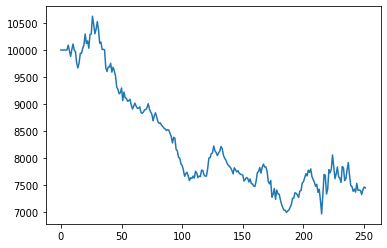

In [26]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [27]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.255350
Cumulative returns    -0.255350
Annual volatility      0.217373
Sharpe ratio          -1.252962
Calmar ratio          -0.741627
Stability              0.784744
Max drawdown          -0.344311
Omega ratio            0.805421
Sortino ratio         -1.739329
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.779021
Daily value at risk   -0.028467
dtype: float64


In [28]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^GSPC", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return          0.112517
Cumulative returns     0.112046
Annual volatility      0.149492
Sharpe ratio           0.790765
Calmar ratio           0.862325
Stability              0.388079
Max drawdown          -0.130481
Omega ratio            1.139645
Sortino ratio          1.131726
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.856084
Daily value at risk   -0.018365
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.43,2021-05-12,2022-02-09,NaT,NaN
1,4.38,2021-04-20,2021-04-26,2021-05-04,11
2,2.56,2021-05-04,2021-05-07,2021-05-11,6
3,2.05,2021-04-14,2021-04-16,2021-04-20,5
4,0.02,2021-04-09,2021-04-12,2021-04-14,4


Stress Events,mean,min,max
New Normal,-0.11%,-4.52%,5.24%


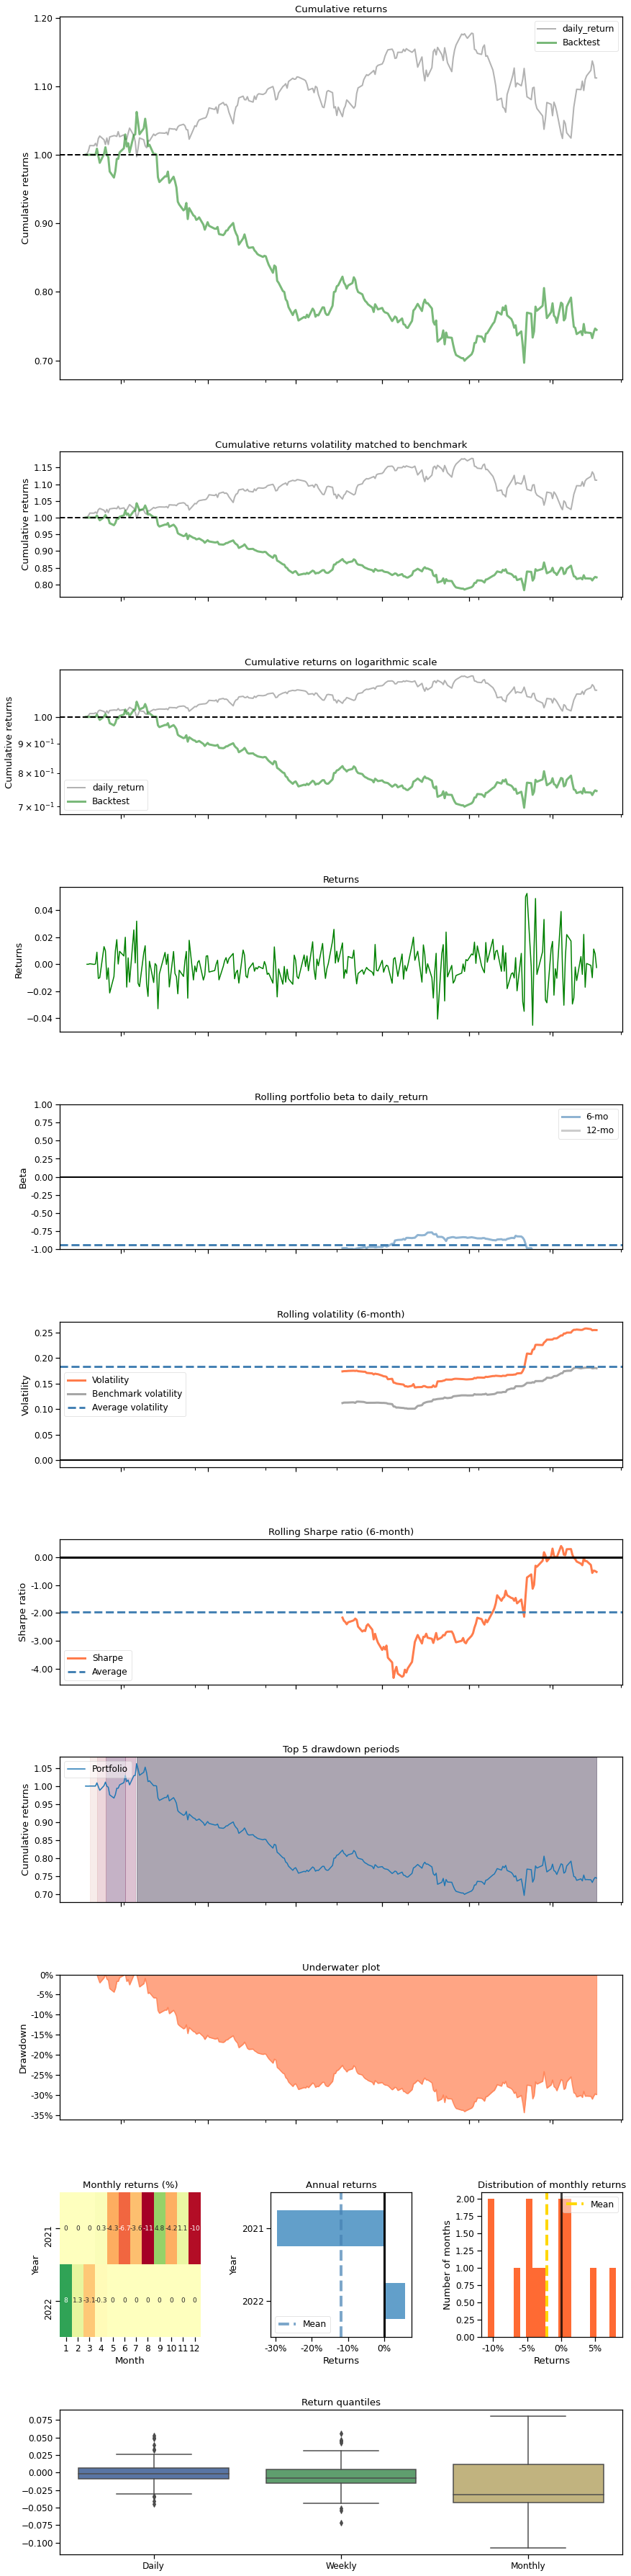

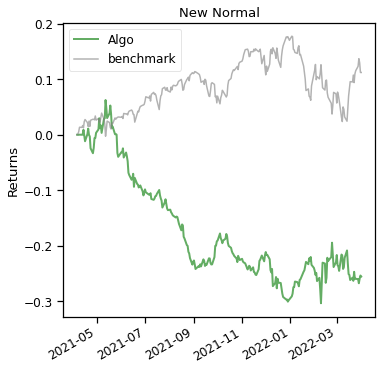

In [29]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^GSPC', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])